# Pseudobulk differential expression to compare BL 2 hours vs BRZ

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex hea

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
rc.integrated <- readRDS("../data/integrations/rc.integrated_14S_BR_Li_seu3_clean.rds")

In [4]:
rc.integrated

An object of class Seurat 
71231 features across 79982 samples within 3 assays 
Active assay: integrated (17732 features, 17732 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [5]:
feature_names <- read_tsv("./data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




# Differential State Analysis with Muscat

In [6]:
# subset BRZ and BL 2 hour samples only samples you want to compare

integrated.de <- subset(rc.integrated, subset = sample %in% c("sc_2", "sc_5", "sc_43","sc_46","sc_49","sc_50"))


In [7]:
integrated.de

An object of class Seurat 
71231 features across 43748 samples within 3 assays 
Active assay: integrated (17732 features, 17732 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

In [8]:
# code control vs treated manually

integrated.de$treated <- integrated.de$time_trt %in% c("2_hour_BL")

table(integrated.de$treated)
table(integrated.de$sample)

integrated.de$treatment <- as.character(integrated.de$treated)

integrated.de$treatment<- gsub("TRUE", "BL", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)
  
integrated.de$treatment<- gsub("FALSE", "BRZ", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

integrated.de$treatment <- factor(integrated.de$treatment, levels=c("BRZ", "BL"))


table(integrated.de$treatment)


FALSE  TRUE 
21473 22275 


 sc_2 sc_43 sc_46 sc_49  sc_5 sc_50 
 7512  8874  6847  5638  9790  5087 


  BRZ    BL 
21473 22275 

In [9]:
table(integrated.de$time_zone_cell_type, integrated.de$sample)

                                       
                                        sc_2 sc_43 sc_46 sc_49 sc_5 sc_50
  Distal Columella                       928   226   154   182  781   310
  Distal Lateral Root Cap                552   208   309   276  774   375
  Elongation_Atrichoblast                157   271   259   221  423   201
  Elongation_Cortex                      267   250   435   298  355   122
  Elongation_Endodermis                  276   399   383   327  536   224
  Elongation_Pericycle                   467   969   702   677  678   487
  Elongation_Phloem                      100   235   206   167  165   137
  Elongation_Procambium                  189   895   758   693  324   521
  Elongation_Trichoblast                 245   610   141   116  170    93
  Elongation_Xylem                       149   310   270   206  227   173
  Maturation_Atrichoblast                 62   319   144   142  199   169
  Maturation_Cortex                       70    91    24    47   77    6

## Convert to sce

In [10]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample,
                              group_id = integrated.de$treatment,
                              cluster_id = integrated.de$time_zone_cell_type, 
                             date=integrated.de$date)

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [11]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 28725 43748 
metadata(1): experiment_info
assays(1): counts
rownames(28725): AT1G01010 AT1G01020 ... AT4G23310 AT4G23580
rowData names(0):
colnames(43748): AAACCCAAGAGGCCAT_3 AAACCCAAGCCTGTGC_3 ...
  TTTGTTGGTGGATACG_12 TTTGTTGTCTGAGAAA_12
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [12]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 27216 43748

In [13]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 23689 43748

In [14]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Distal Columella"                     
 [2] "Distal Lateral Root Cap"              
 [3] "Elongation_Atrichoblast"              
 [4] "Elongation_Cortex"                    
 [5] "Elongation_Endodermis"                
 [6] "Elongation_Pericycle"                 
 [7] "Elongation_Phloem"                    
 [8] "Elongation_Procambium"                
 [9] "Elongation_Trichoblast"               
[10] "Elongation_Xylem"                     
[11] "Maturation_Atrichoblast"              
[12] "Maturation_Cortex"                    
[13] "Maturation_Endodermis"                
[14] "Maturation_Pericycle"                 
[15] "Maturation_Phloem"                    
[16] "Maturation_Procambium"                
[17] "Maturation_Trichoblast"               
[18] "Maturation_Xylem"                     
[19] "Proliferation Domain_Atrichoblast"    
[20] "Proliferation Domain_Cortex"          
[21] "Proliferation Domain_Endodermis"      
[22] "Proliferation Domain_Pericycle"       
[23] "Proliferation Domain_Phloem"          
[24] "Proliferation Domain_Quiescent Center"
[25] "Proliferation Domain_Trichoblast"     
[26] "Proliferation Domain_Xylem"           
[27] "Proximal Columella"                   
[28] "Proximal Lateral Root Cap"            
[29] "Transition Domain_Atrichoblast"       
[30] "Transition Domain_Cortex"             
[31] "Transition Domain_Endodermis"         
[32] "Transition Domain_Pericycle"          
[33] "Transition Domain_Phloem"             
[34] "Transition Domain_Procambium"         
[35] "Transition Domain_Trichoblast"        
[36] "Transition Domain_Xylem"

In [15]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

AT1G01010 AT1G01020 AT1G01030 AT1G01040 AT1G01050 AT1G01060
sc_2  109       91        38        45        487       5        
sc_43   3       22        13        10        206       0        
sc_46   3       21         9         9        344       0        
sc_49   9       30         8        11        394       0        
sc_5   66       64        20        28        403       1        
sc_50   5       29        11        10        326       0

In [16]:
  bscs <- read.csv("../data/Benfey_single_cell-Samples.csv", na.strings=c("","NA"), stringsAsFactors = F)
  bscs <- bscs %>% select(c('sample','name','source','genotype','transgene','treatment','age','timepoint','rep','target_cells','date','seq_run'))
  bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)
  bscs$target_cells <- prettyNum(bscs$target_cells, big.mark = ',')

In [17]:
# experiment info for contrasts, add dates from csv

ei <- metadata(sce)$experiment_info
ei

sample_date <- select(bscs, sample_id=sample, date)

ei <- left_join(ei, sample_date)

ei

sample_id group_id n_cells
1 sc_2      BRZ      7512   
2 sc_5      BL       9790   
3 sc_43     BRZ      8874   
4 sc_46     BL       6847   
5 sc_49     BL       5638   
6 sc_50     BRZ      5087

Joining, by = "sample_id"



sample_id group_id n_cells date      
1 sc_2      BRZ      7512    2019-12-14
2 sc_5      BL       9790    2019-12-14
3 sc_43     BRZ      8874    2020-02-12
4 sc_46     BL       6847    2020-02-12
5 sc_49     BL       5638    2020-02-12
6 sc_50     BRZ      5087    2020-02-12

In [18]:
mm <- model.matrix(~ 0 + ei$group_id + ei$date)
dimnames(mm) <- list(ei$sample_id, c(levels(ei$group_id), "date"))

mm

BRZ BL date
sc_2  1   0  0   
sc_5  0   1  0   
sc_43 1   0  1   
sc_46 0   1  1   
sc_49 0   1  1   
sc_50 1   0  1

In [19]:
contrast <- makeContrasts("BL-BRZ", levels = mm)

contrast

Contrasts
Levels BL-BRZ
  BRZ  -1    
  BL    1    
  date  0

In [20]:
res <- pbDS(pb, design = mm, 
            contrast = contrast, 
            method="edgeR", 
            min_cells=5, 
            filter = c("none"))

Distal Columella..Distal Lateral Root Cap..Elongation_Atrichoblast..Elongation_Cortex..Elongation_Endodermis..Elongation_Pericycle..Elongation_Phloem..Elongation_Procambium..Elongation_Trichoblast..Elongation_Xylem..Maturation_Atrichoblast..Maturation_Cortex..Maturation_Endodermis..Maturation_Pericycle..Maturation_Phloem..Maturation_Procambium..Maturation_Trichoblast..Maturation_Xylem..Proliferation Domain_Atrichoblast..Proliferation Domain_Cortex..Proliferation Domain_Endodermis..Proliferation Domain_Pericycle..Proliferation Domain_Phloem..Proliferation Domain_Quiescent Center..Proliferation Domain_Trichoblast..Proliferation Domain_Xylem..Proximal Columella..Proximal Lateral Root Cap..Transition Domain_Atrichoblast..Transition Domain_Cortex..Transition Domain_Endodermis..Transition Domain_Pericycle..Transition Domain_Phloem..Transition Domain_Procambium..Transition Domain_Trichoblast..Transition Domain_Xylem..

### DEG results

In [21]:
# DEG results with gene freqs
(res_to_write_frq <- resDS(sce, res, bind = "row", cpm=TRUE, frq=T))

gene      cluster_id                    sc_2.cpm sc_43.cpm sc_50.cpm
1      AT1G01010 Distal Columella               22.700    2.070     3.200  
2      AT1G01020 Distal Columella               19.000   15.200    18.500  
3      AT1G01030 Distal Columella                7.920    8.990     7.030  
4      AT1G01040 Distal Columella                9.380    6.910     6.390  
5      AT1G01050 Distal Columella              101.000  142.000   208.000  
6      AT1G01060 Distal Columella                1.040    0.000     0.000  
7      AT1G01070 Distal Columella                0.000    0.000     0.000  
8      AT1G01080 Distal Columella                0.000    0.691     0.000  
9      AT1G01090 Distal Columella               38.100   37.300    24.900  
10     AT1G01100 Distal Columella              125.000  164.000   136.000  
11     AT1G01110 Distal Columella                1.880    2.070     0.639  
12     AT1G01120 Distal Columella                1.460    0.000     0.000  
13     AT1G01130 Distal Columella                0.417    0.691     0.000  
14     AT1G01140 Distal Columella                4.380    0.691     0.639  
15     AT1G01160 Distal Columella               11.500   15.900    12.100  
16     AT1G01170 Distal Columella                0.000    3.460     1.280  
17     AT1G01180 Distal Columella               42.100   29.000    26.200  
18     AT1G01200 Distal Columella                1.040    0.000     1.280  
19     AT1G01210 Distal Columella                1.670    2.070     0.000  
20     AT1G01220 Distal Columella                4.790    4.840     4.470  
21     AT1G01225 Distal Columella                1.670    0.691     0.639  
22     AT1G01230 Distal Columella               35.400   32.500    33.200  
23     AT1G01240 Distal Columella               26.700   26.300    30.000  
24     AT1G01260 Distal Columella               41.000   48.400    40.900  
25     AT1G01280 Distal Columella                0.000    0.000     0.639  
26     AT1G01290 Distal Columella                2.710    3.460     4.470  
27     AT1G01300 Distal Columella               10.800   23.500     6.390  
28     AT1G01310 Distal Columella                0.208    0.000     0.000  
29     AT1G01320 Distal Columella                7.710    6.220     7.670  
30     AT1G01340 Distal Columella                0.625    0.000     1.280  
⋮      ⋮         ⋮                             ⋮        ⋮         ⋮        
613549 AT4G29450 Transition Domain_Trichoblast   0.00   0.000     0.000    
613550 AT4G29970 Transition Domain_Trichoblast   0.00   0.000     0.000    
613551 ATCG00030 Transition Domain_Trichoblast 177.00   0.000     0.000    
613552 AT1G04053 Transition Domain_Trichoblast   0.16   0.000     0.000    
613553 AT1G19371 Transition Domain_Trichoblast   0.16   0.000     0.000    
613554 AT1G27045 Transition Domain_Trichoblast   0.00   0.000     0.000    
613555 AT1G50470 Transition Domain_Trichoblast   0.00   0.000     0.000    
613556 AT1G55755 Transition Domain_Trichoblast   0.00   0.000     0.000    
613557 AT1G74290 Transition Domain_Trichoblast   0.00   0.638     0.000    
613558 AT1G74820 Transition Domain_Trichoblast   0.00   0.000     0.000    
613559 AT5G04395 Transition Domain_Trichoblast   0.00   0.000     0.000    
613560 AT5G52710 Transition Domain_Trichoblast   0.00   0.000     0.000    
613561 AT5G60265 Transition Domain_Trichoblast   0.00   0.000     0.000    
613562 AT3G04390 Transition Domain_Trichoblast   0.16   0.000     0.000    
613563 AT3G45180 Transition Domain_Trichoblast   0.00   0.000     0.000    
613564 AT2G01918 Transition Domain_Trichoblast   0.00   0.000     0.552    
613565 AT2G05786 Transition Domain_Trichoblast   0.16   0.000     0.000    
613566 AT2G27670 Transition Domain_Trichoblast   0.00   0.000     0.276    
613567 AT4G17580 Transition Domain_Trichoblast   0.00   0.000     0.000    
613568 AT4G36260 Transition Domain_Trichoblast   0.00   0.426     0.000    
613569 AT4G36370 Transition Domain_Trichoblast   0.32  

In [22]:
## all genes background 

all_bg <- filter(res_to_write_frq,
                BRZ.frq >=0.1 | BL.frq >=0.1)

In [23]:
length(unique(all_bg$gene))

[1] 18126

In [24]:
#total DE genes p_adj.loc < 0.05, abs(logFC) > 1.5
sig_DE <- filter(res_to_write_frq, p_adj.loc<=0.05 & abs(logFC) > log2(1.5))
sig_DE <- left_join(sig_DE, feature_names, by=c("gene"="AGI"))

length(unique(sig_DE$gene))

[1] 10149

In [25]:
# filter gene freqs to avoid calling lowly detected genes
sig_DE_fil <- filter(sig_DE, BRZ.frq >=0.1 | BL.frq >=0.1)

In [26]:
length(unique(sig_DE_fil$gene))

[1] 8286

In [27]:
# load TFs
TF_list <- read_csv("./data/Kay_TF_thalemine_annotations.csv", col_names = c("gene", "TF_Name", "Description")) 


── Column specification ────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  TF_Name = col_character(),
  Description = col_character()
)




In [28]:
sig_DE_fil <- left_join(sig_DE_fil, TF_list)

Joining, by = "gene"



In [29]:
# label up vs down
sig_DE_fil <- sig_DE_fil %>%
  mutate(up_dn_label = case_when(logFC >=log2(1.5) ~ "Up",  
                                       logFC <=log2(1/1.5) ~ "Down",
                                       TRUE ~ "Not DE"))

sig_DE_fil$clust_up_dn <- paste(sig_DE_fil$cluster_id, sig_DE_fil$up_dn_label, sep="_")

sig_DE_fil

gene      cluster_id                    sc_2.cpm sc_43.cpm sc_50.cpm
1     AT1G01300 Distal Columella                10.80    23.50      6.39  
2     AT1G01580 Distal Columella                33.30    45.60     32.00  
3     AT1G01620 Distal Columella               129.00    36.60     34.50  
4     AT1G02930 Distal Columella               116.00    96.80    176.00  
5     AT1G03070 Distal Columella                19.60    38.00     63.30  
6     AT1G03220 Distal Columella              6900.00  5590.00   7180.00  
7     AT1G03870 Distal Columella                71.90    13.10     12.10  
8     AT1G04430 Distal Columella                17.30    21.40     24.90  
9     AT1G04680 Distal Columella                 8.75     7.60      8.31  
10    AT1G04820 Distal Columella               124.00   142.00    120.00  
11    AT1G05100 Distal Columella               133.00    85.00     68.40  
12    AT1G05205 Distal Columella                56.50    63.60     34.50  
13    AT1G05680 Distal Columella              1050.00   160.00    146.00  
14    AT1G05810 Distal Columella                19.20    15.90     17.90  
15    AT1G05870 Distal Columella                10.80     8.99      5.75  
16    AT1G06040 Distal Columella                13.50    18.70     13.40  
17    AT1G06090 Distal Columella               149.00   217.00    765.00  
18    AT1G06330 Distal Columella                10.40    22.80     21.10  
19    AT1G06800 Distal Columella                31.70    20.70     26.80  
20    AT1G06840 Distal Columella                60.00    36.60     53.70  
21    AT1G07150 Distal Columella                87.90    46.30     39.60  
22    AT1G07175 Distal Columella                72.70    39.40     44.70  
23    AT1G07280 Distal Columella                72.30    96.10     67.80  
24    AT1G07350 Distal Columella               134.00   178.00    282.00  
25    AT1G07400 Distal Columella                87.90   166.00    917.00  
26    AT1G07610 Distal Columella               604.00   462.00    489.00  
27    AT1G08650 Distal Columella                20.40    14.50     30.70  
28    AT1G08920 Distal Columella                69.00    46.30     94.60  
29    AT1G09210 Distal Columella                83.60    91.90     61.40  
30    AT1G09630 Distal Columella                16.70    24.90     17.30  
⋮     ⋮         ⋮                             ⋮        ⋮         ⋮        
28289 AT4G36500 Transition Domain_Trichoblast 739.00   726.000   776.00   
28290 AT4G36730 Transition Domain_Trichoblast  36.00    22.800    20.70   
28291 AT4G36780 Transition Domain_Trichoblast 161.00   171.000   143.00   
28292 AT4G36790 Transition Domain_Trichoblast  36.80    36.600    33.10   
28293 AT4G36880 Transition Domain_Trichoblast  97.70   108.000   116.00   
28294 AT4G36920 Transition Domain_Trichoblast  21.90    19.200    16.30   
28295 AT4G36990 Transition Domain_Trichoblast  32.00    27.200    24.80   
28296 AT4G37235 Transition Domain_Trichoblast   0.16     0.213     0.00   
28297 AT4G37260 Transition Domain_Trichoblast  19.70    24.500    18.50   
28298 AT4G37320 Transition Domain_Trichoblast   7.99     4.680     5.24   
28299 AT4G37370 Transition Domain_Trichoblast   5.44     2.770     3.03   
28300 AT4G37450 Transition Domain_Trichoblast  12.90    27.900    24.00   
28301 AT4G37610 Transition Domain_Trichoblast  91.90    88.300    66.50   
28302 AT4G37790 Transition Domain_Trichoblast  12.90    11.100    19.30   
28303 AT4G37910 Transition Domain_Trichoblast 276.00   116.000   111.00   
28304 AT4G37940 Transition Domain_Trichoblast  17.70    16.600    15.50   
28305 AT4G38130 Transition Domain_Trichoblast  41.90    51.900    37.80   
28306 AT4G38140 Transition Domain_Trichoblast  33.10    33.000    31.20   
28307 AT4G38400 Transition Domain_Trichoblast   7.35     2.130     4.97   
28308 AT4G38460 Transition Domain_Trichoblast  26.70    39.600    35.90   
28309 AT4G38740 Transition Domain_Trichoblast 138.00   177.000   153.00   
28310 AT4G39070 Transition Doma

In [30]:
sig_DE_fil
write.csv(sig_DE_fil, file = "./output/v4_BL2hr_v_BRZ_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

gene      cluster_id                    sc_2.cpm sc_43.cpm sc_50.cpm
1     AT1G01300 Distal Columella                10.80    23.50      6.39  
2     AT1G01580 Distal Columella                33.30    45.60     32.00  
3     AT1G01620 Distal Columella               129.00    36.60     34.50  
4     AT1G02930 Distal Columella               116.00    96.80    176.00  
5     AT1G03070 Distal Columella                19.60    38.00     63.30  
6     AT1G03220 Distal Columella              6900.00  5590.00   7180.00  
7     AT1G03870 Distal Columella                71.90    13.10     12.10  
8     AT1G04430 Distal Columella                17.30    21.40     24.90  
9     AT1G04680 Distal Columella                 8.75     7.60      8.31  
10    AT1G04820 Distal Columella               124.00   142.00    120.00  
11    AT1G05100 Distal Columella               133.00    85.00     68.40  
12    AT1G05205 Distal Columella                56.50    63.60     34.50  
13    AT1G05680 Distal Columella              1050.00   160.00    146.00  
14    AT1G05810 Distal Columella                19.20    15.90     17.90  
15    AT1G05870 Distal Columella                10.80     8.99      5.75  
16    AT1G06040 Distal Columella                13.50    18.70     13.40  
17    AT1G06090 Distal Columella               149.00   217.00    765.00  
18    AT1G06330 Distal Columella                10.40    22.80     21.10  
19    AT1G06800 Distal Columella                31.70    20.70     26.80  
20    AT1G06840 Distal Columella                60.00    36.60     53.70  
21    AT1G07150 Distal Columella                87.90    46.30     39.60  
22    AT1G07175 Distal Columella                72.70    39.40     44.70  
23    AT1G07280 Distal Columella                72.30    96.10     67.80  
24    AT1G07350 Distal Columella               134.00   178.00    282.00  
25    AT1G07400 Distal Columella                87.90   166.00    917.00  
26    AT1G07610 Distal Columella               604.00   462.00    489.00  
27    AT1G08650 Distal Columella                20.40    14.50     30.70  
28    AT1G08920 Distal Columella                69.00    46.30     94.60  
29    AT1G09210 Distal Columella                83.60    91.90     61.40  
30    AT1G09630 Distal Columella                16.70    24.90     17.30  
⋮     ⋮         ⋮                             ⋮        ⋮         ⋮        
28289 AT4G36500 Transition Domain_Trichoblast 739.00   726.000   776.00   
28290 AT4G36730 Transition Domain_Trichoblast  36.00    22.800    20.70   
28291 AT4G36780 Transition Domain_Trichoblast 161.00   171.000   143.00   
28292 AT4G36790 Transition Domain_Trichoblast  36.80    36.600    33.10   
28293 AT4G36880 Transition Domain_Trichoblast  97.70   108.000   116.00   
28294 AT4G36920 Transition Domain_Trichoblast  21.90    19.200    16.30   
28295 AT4G36990 Transition Domain_Trichoblast  32.00    27.200    24.80   
28296 AT4G37235 Transition Domain_Trichoblast   0.16     0.213     0.00   
28297 AT4G37260 Transition Domain_Trichoblast  19.70    24.500    18.50   
28298 AT4G37320 Transition Domain_Trichoblast   7.99     4.680     5.24   
28299 AT4G37370 Transition Domain_Trichoblast   5.44     2.770     3.03   
28300 AT4G37450 Transition Domain_Trichoblast  12.90    27.900    24.00   
28301 AT4G37610 Transition Domain_Trichoblast  91.90    88.300    66.50   
28302 AT4G37790 Transition Domain_Trichoblast  12.90    11.100    19.30   
28303 AT4G37910 Transition Domain_Trichoblast 276.00   116.000   111.00   
28304 AT4G37940 Transition Domain_Trichoblast  17.70    16.600    15.50   
28305 AT4G38130 Transition Domain_Trichoblast  41.90    51.900    37.80   
28306 AT4G38140 Transition Domain_Trichoblast  33.10    33.000    31.20   
28307 AT4G38400 Transition Domain_Trichoblast   7.35     2.130     4.97   
28308 AT4G38460 Transition Domain_Trichoblast  26.70    39.600    35.90   
28309 AT4G38740 Transition Domain_Trichoblast 138.00   177.000   153.00   
28310 AT4G39070 Transition Doma

In [31]:
# add DE and up/dn to total list
sig_to_join <- sig_DE_fil %>%
mutate(clust_gene=paste(cluster_id, gene, sep="_")) %>%
select(clust_gene, up_dn_label, clust_up_dn)

In [32]:
# join all genes list to DE labels
all_bg <- mutate(all_bg, clust_gene=paste(cluster_id, gene, sep="_"))

all_bg <- left_join(all_bg, feature_names, by=c("gene"="AGI"))

all_bg$DE <- all_bg$clust_gene %in% sig_to_join$clust_gene


all_bg <- all_bg %>%
left_join(sig_to_join, by="clust_gene") %>%
arrange(all_bg, p_adj.loc)

write.csv(all_bg, file = "./output/v4_all_BL2hr_v_BRZ_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

### Number of DEGs per subpopulation

In [33]:
nb_genes_per_clust <- sig_DE_fil  %>%
  group_by(cluster_id) %>%
  tally()



nb_de_gene_count <- sig_DE_fil %>%
  group_by(gene) %>%
  tally(name = "n_clusters_de")

 

nb_cluster_DE_sig <- left_join(sig_DE_fil, nb_de_gene_count)

# color up and down

nb_up_dn <- sig_DE_fil  %>%
  group_by(cluster_id, up_dn_label) %>%
  tally(name = "n_up_dn") %>%
left_join(nb_genes_per_clust)



Joining, by = "gene"

Joining, by = "cluster_id"



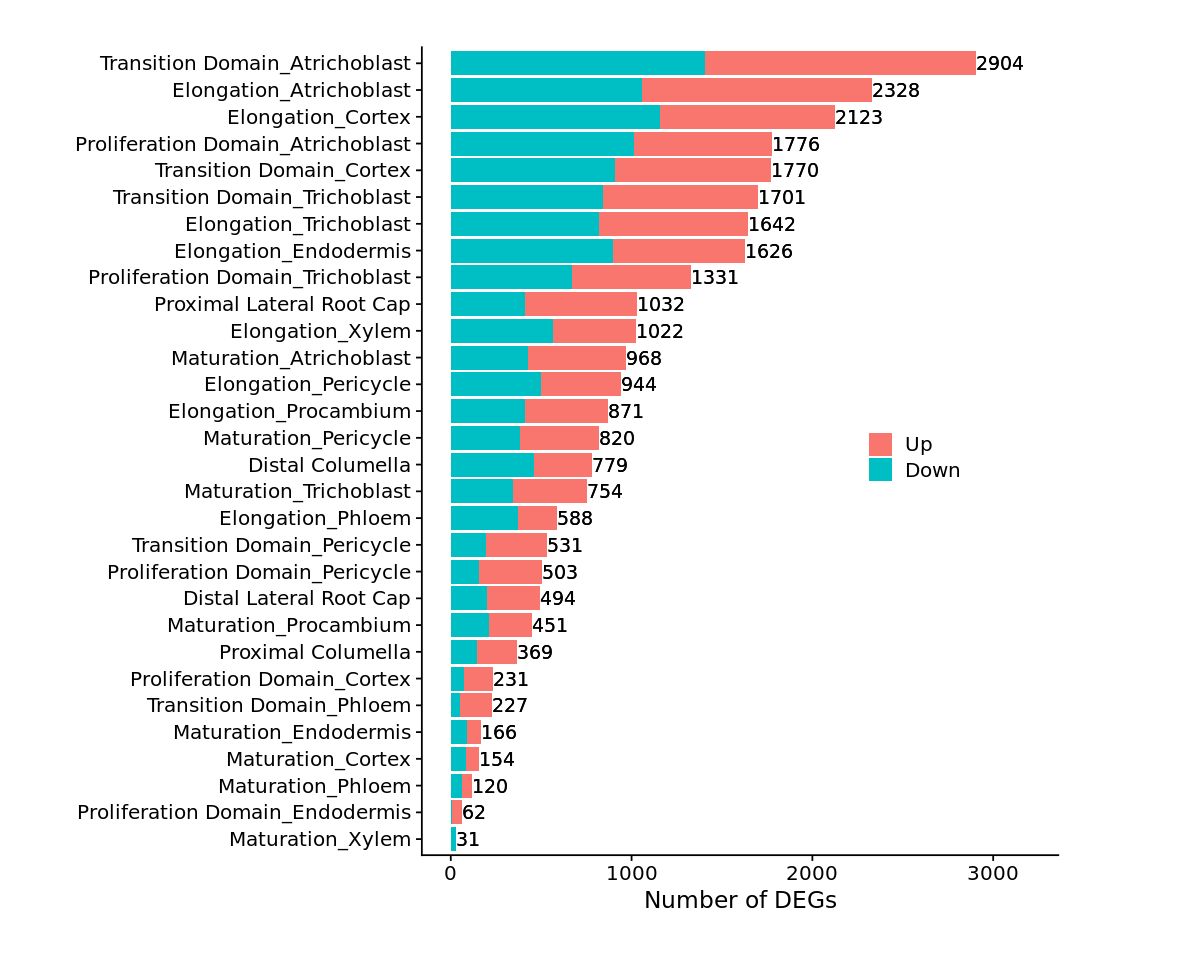

In [34]:
options(repr.plot.width=10, repr.plot.height=8)

nb_v <- ggplot(data=nb_up_dn, aes(x=reorder(cluster_id, n), y=n_up_dn, fill=factor(up_dn_label, levels=c("Up", "Down")))) +
  geom_bar(stat="identity", position="stack") + ylab("Number of DEGs") + xlab("") + 
scale_y_continuous(limits = c(0, 3200)) +
geom_text(aes(label=n, y = n), hjust=0, vjust=0.5, size=4)  + 
theme_cowplot()  +theme(plot.margin = margin(1,3,1,1, "cm"), 
                        legend.title=element_blank(), 
                       legend.position = c(0.7, 0.5))

(de_up_dn_bar_v <- nb_v + coord_flip())

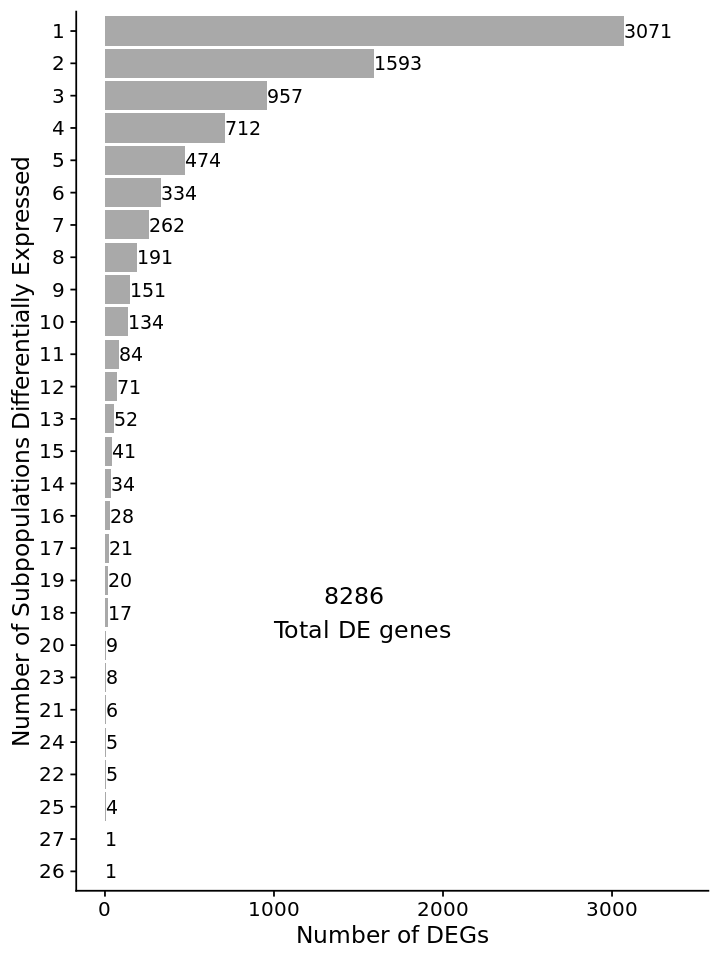

In [35]:
options(repr.plot.width=6, repr.plot.height=8)

# get number of times a gene is DE across the number of clusters
gene_de_n <- nb_de_gene_count %>%
  group_by(n_clusters_de) %>%
  tally()

total_de_gene_number <- length(unique(sig_DE_fil$gene))


total_de_gene_number_label <- paste(length(unique(sig_DE_fil$gene)), "\n Total DE genes", sep = " ")

#can toggle colors below to highlight first bar
gene_de_n$highlight <- c("yes", rep("no", (nrow(gene_de_n)-1)))

nb_gene_p3<-ggplot(data=gene_de_n, aes(x=reorder(n_clusters_de, n), y=n, fill=highlight)) +
  geom_bar(stat="identity") + 
  ylab("Number of DEGs") + 
  xlab("Number of Subpopulations Differentially Expressed") + 
  geom_text(aes(label=n), hjust=0, vjust=0.5, size=4) + 
  annotate("text", x = 9, y=1500, label=total_de_gene_number_label, size=5) + 
  scale_fill_manual(values = c("darkgrey", "darkgrey")) + 
scale_y_continuous(limits = c(0, 3400)) +
  theme(legend.position = "none") + theme_cowplot() + NoLegend()



(subpop_bar_v <- nb_gene_p3 + coord_flip())

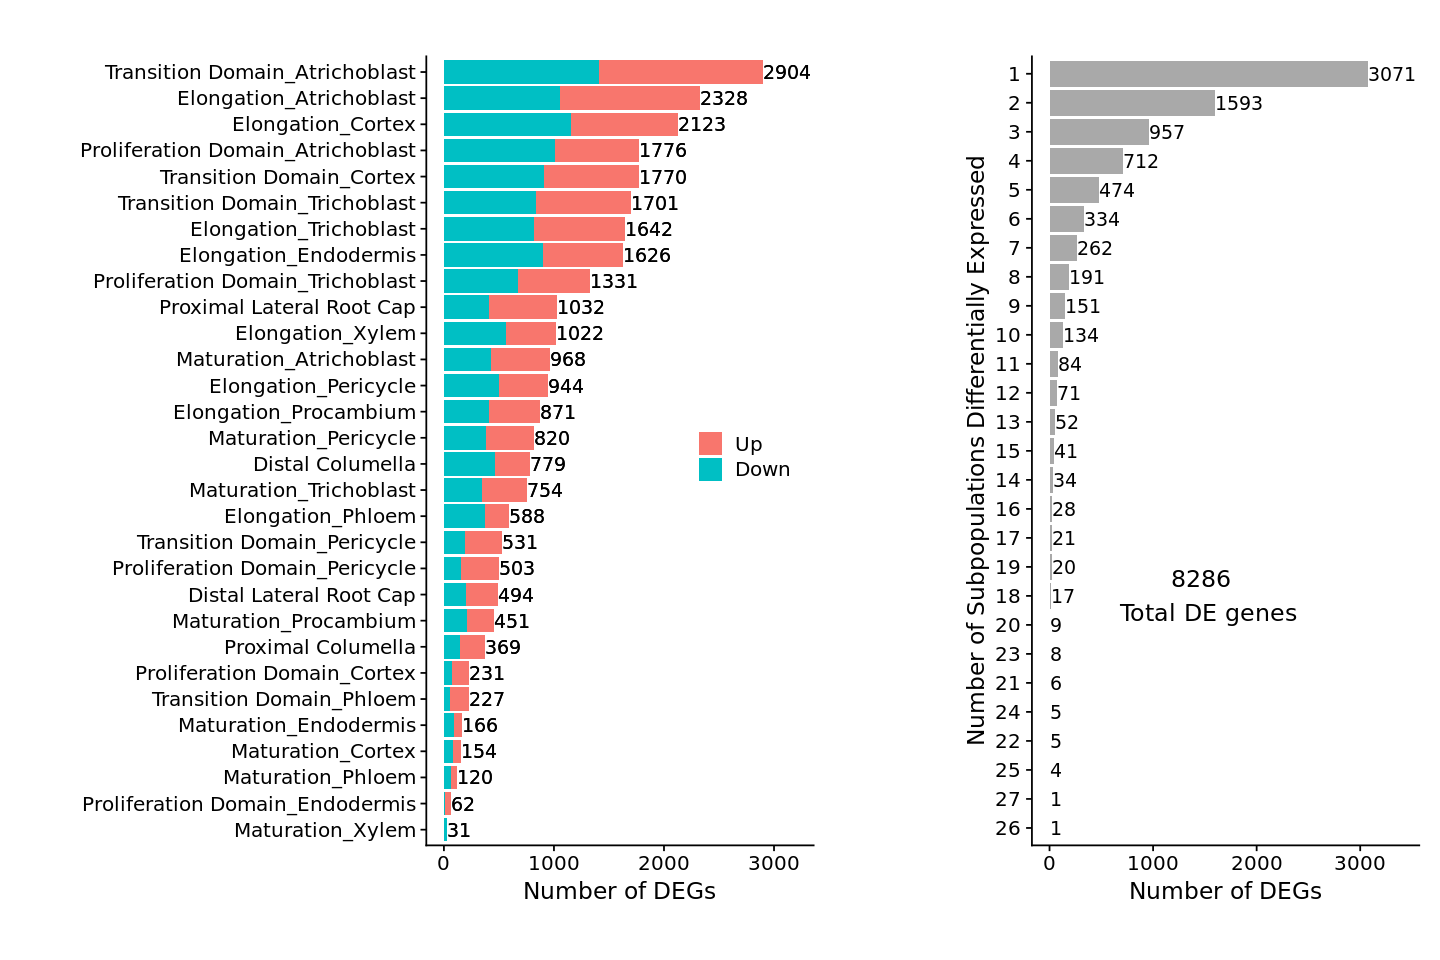

In [36]:
options(repr.plot.width=12, repr.plot.height=8)
de_up_dn_bar_v + subpop_bar_v

ggsave("./output/BL2hr_v_BRZ_vertical_num_DE_genes_w_subpop.pdf", width = 12, height = 8)

## Volcano plots with only DE genes

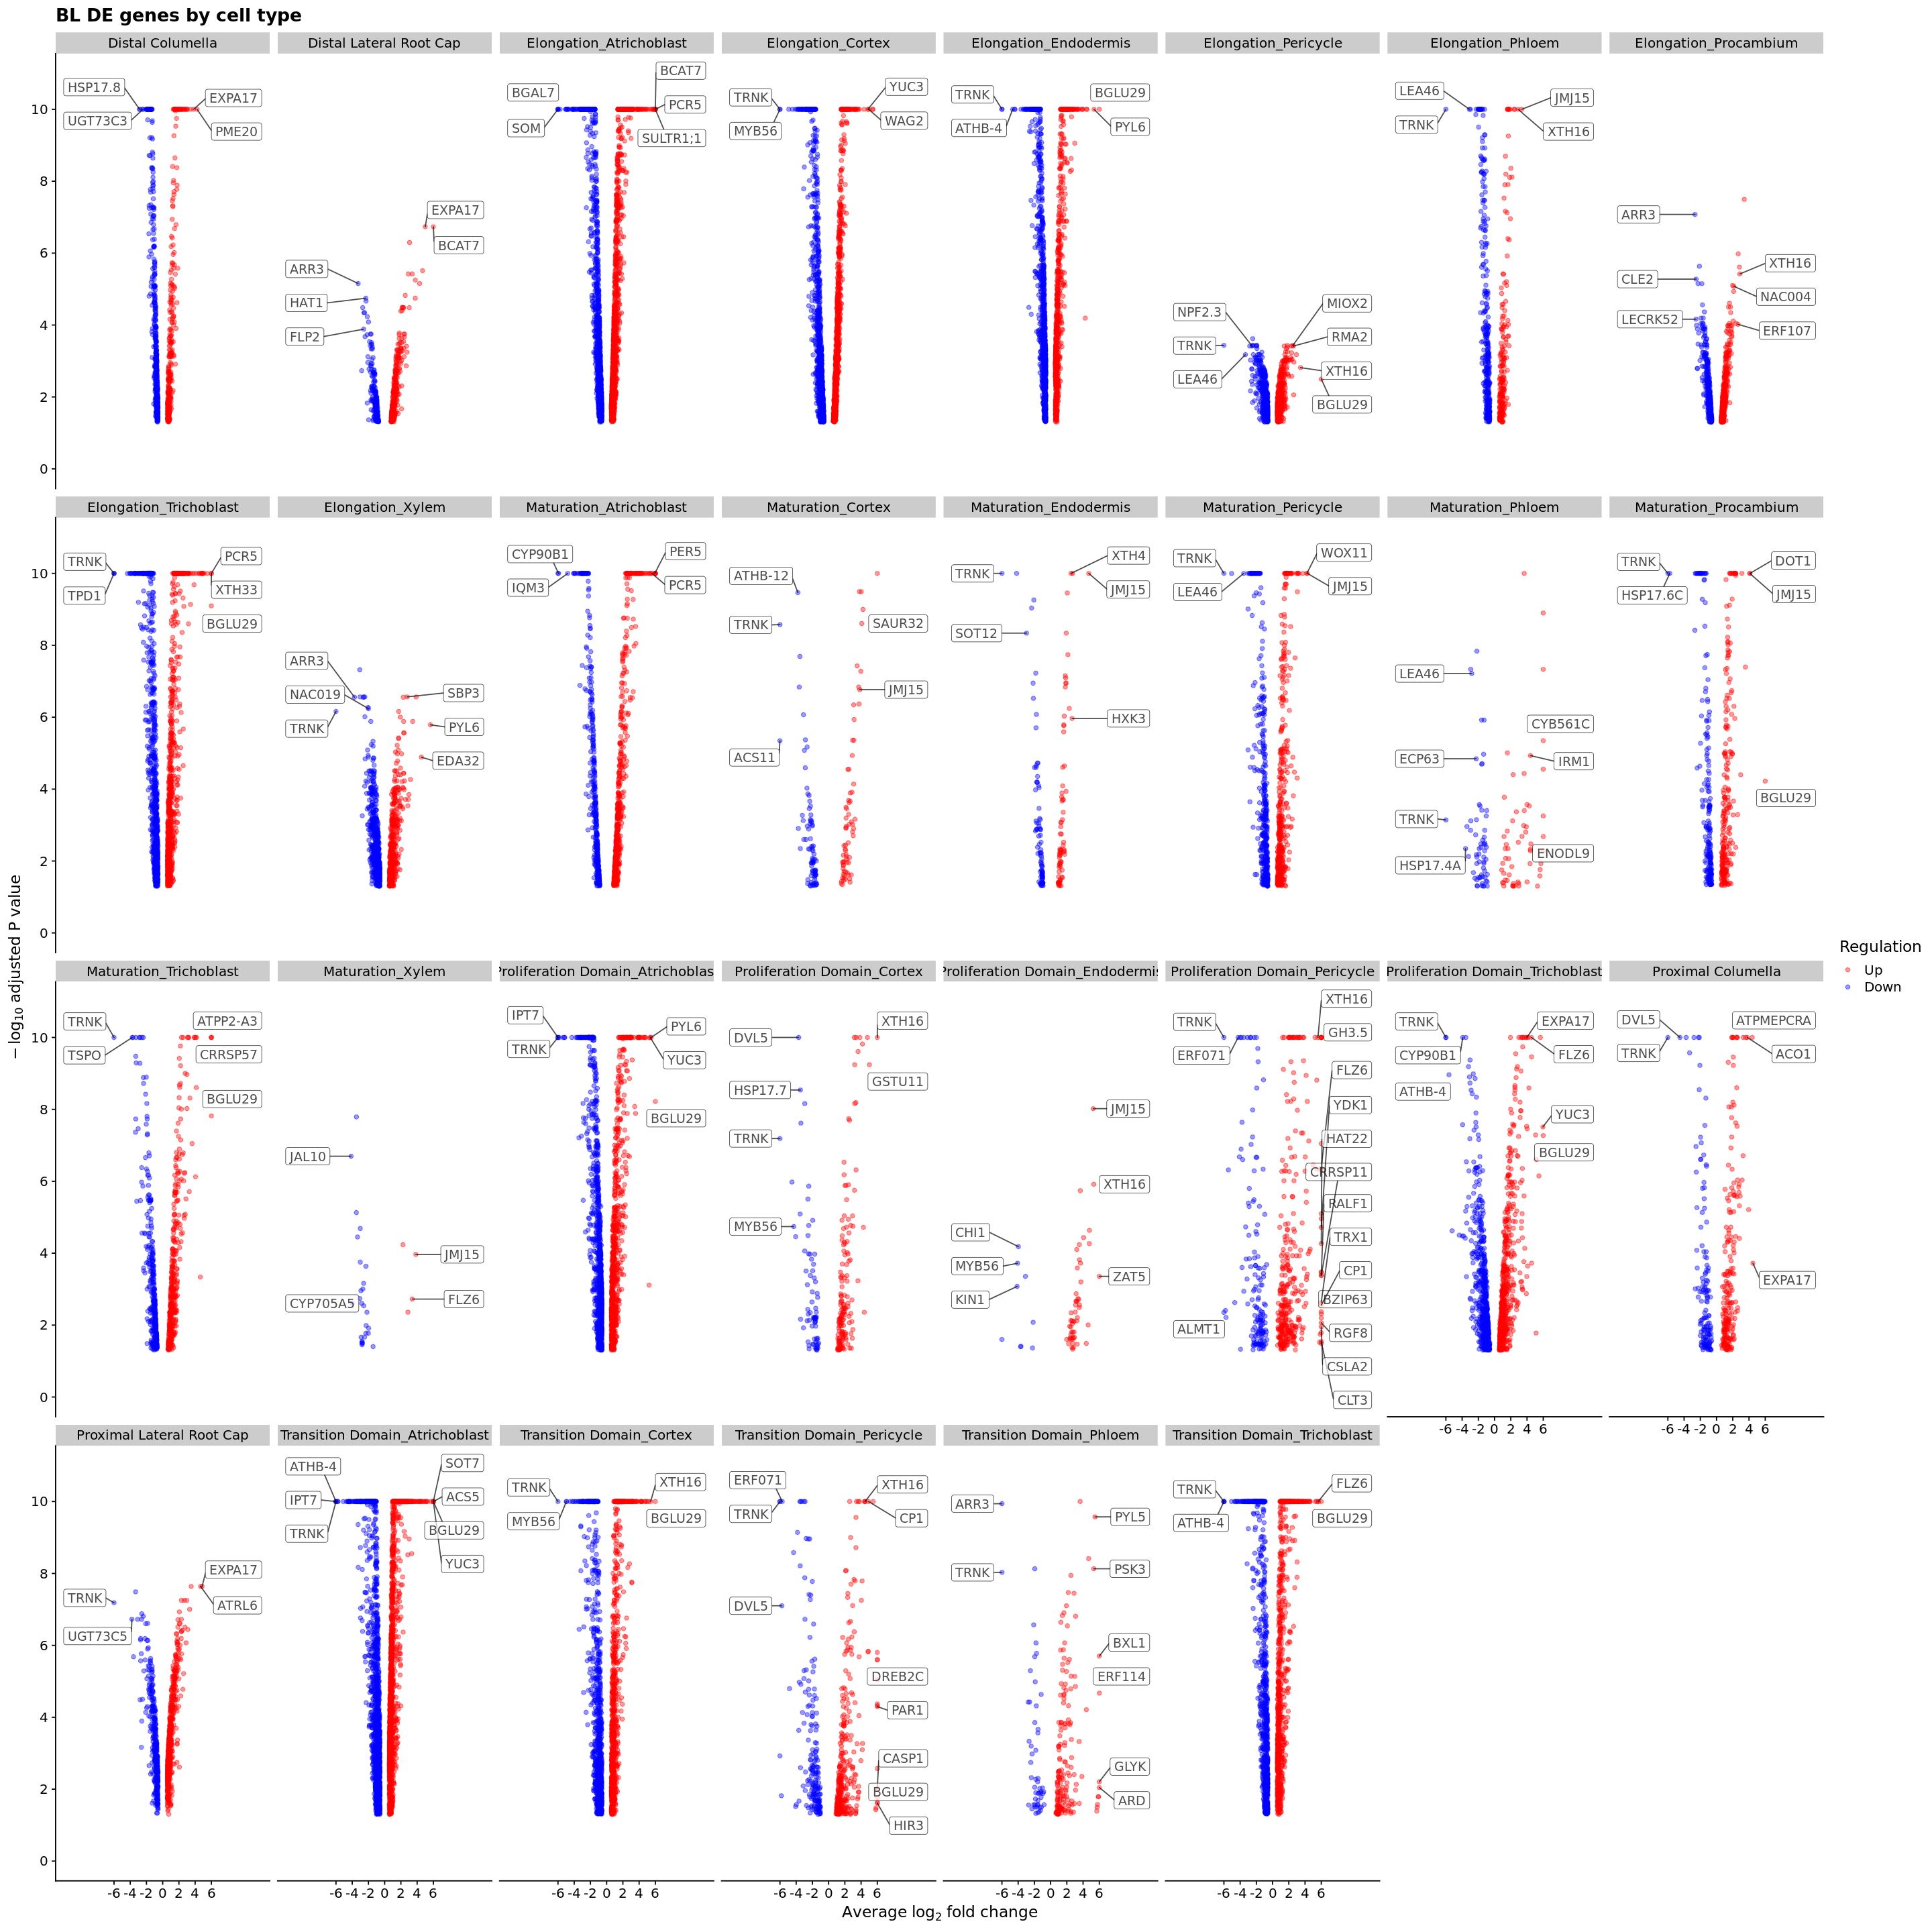

In [37]:
## Volcano plots with only DE genes

options(repr.plot.width = 24, repr.plot.height = 24)
nb_de_total_names <- sig_DE_fil

# need combo of cluster and gene 
#nb_de_total_names$sig <- nb_de_total_names$gene_id %in% nb_DE_sig$gene_id

#nb_de_total_names$known_drought <- nb_de_total_names$gene_id %in% drought_names$gene_id

# nb_de_total_names %>%
#   group_by(gene_id) %>%
#   filter(known_drought==T & sig==T) %>%
#   ungroup() %>%
#   select(gene_id) %>%
#   distinct()

nb_de_total_names <- dplyr::rename(nb_de_total_names, log2FC=logFC)

nb_de_total_names$logFDR <- -log10(nb_de_total_names$p_adj.loc)
# color up/down and facet plot 

# filter(nb_de_total, p_val_adj<=0.05) %>%
# filter(avg_logFC>=log2(1.25) | avg_logFC<=log2(3/4))

all_time_pts <- nb_de_total_names %>%
  mutate(up_dn_label = case_when(log2FC >=log2(1.25) ~ "Up",  
                                       log2FC <=log2(3/4) ~ "Down",
                                       TRUE ~ "Not DE"))
all_time_pts$up_dn_label <- factor(all_time_pts$up_dn_label, levels=c("Up", "Down", "Not DE"))


all_time_pts$sig <- all_time_pts$up_dn_label !="Not DE"
# set limits of FC and logFDR
all_time_pts_cut <- all_time_pts
# round to cutoff at 4
all_time_pts_cut$logFDR[all_time_pts_cut$logFDR>10] <- 10

# limit log2FC to 4 
all_time_pts_cut$log2FC[all_time_pts_cut$log2FC>6] <- 6
all_time_pts_cut$log2FC[all_time_pts_cut$log2FC < -6] <- -6

# # labels 
# 
# time.labs <- c("15 min", "30 min", "1 hour", "2 hour", "4 hour", "8 hour")
# names(time.labs) <- c(1, 2, 3, 4, 5, 6)

genes_w_names <- filter(all_time_pts_cut, !grepl("^AT[1-5]", Name) & sig==TRUE)

top_genes_to_label <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(10, logFDR) %>%
  top_n(2, log2FC)
top_genes_to_label2 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(10, logFDR) %>%
  top_n(2, -log2FC)

top_genes_to_label3 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(2, log2FC)
top_genes_to_label4 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(2, -log2FC)

top_genes_to_label <- bind_rows(top_genes_to_label, top_genes_to_label2, top_genes_to_label3, top_genes_to_label4) %>%
  distinct()

up_genes_to_label <- filter(top_genes_to_label, log2FC>0)
down_genes_to_label <- filter(top_genes_to_label, log2FC<0)


p = ggplot(all_time_pts_cut, aes(log2FC, logFDR)) +
  geom_point(aes(col=up_dn_label), alpha = 0.4) +
  scale_color_manual(values=c("red", "blue", "black")) + 
  scale_x_continuous(limits=c(-12, 12), breaks = c(-6, -4, -2, 0, 2, 4, 6)) + scale_y_continuous(limits=c(0, 11), breaks = c(0, 2, 4, 6, 8, 10)) + 
  xlab(expression(Average~log[2]~fold~change)) + 
  ylab(expression(-log[10]~adjusted~P~value)) + 
  scale_alpha(guide="none")

all_plot <- p+ geom_label_repel(data=up_genes_to_label, 
                   aes(label=Name), 
                   size = 4, 
                   nudge_x = 11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) + 
  geom_label_repel(data=down_genes_to_label, 
                   aes(label=Name), 
                   size = 4, 
                   nudge_x = -11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) +
  labs(color = "Regulation") + ggtitle("") + theme_minimal() + theme(plot.title = element_text(hjust = 0.5))



all_plot + facet_wrap(~ cluster_id, nrow = 4) + ggtitle("BL DE genes by cell type") + theme_cowplot()


## Up vs down GO enrichment and overlap analysis

In [38]:
markers_sel <- select(sig_DE_fil, gene, clust_up_dn)

markers_list <- split(markers_sel, f=markers_sel$clust_up_dn)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
                         
cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

In [39]:
# GO for up genes only - top 10 GO across all (not grouped by subpopulation)


up_GO <-cluster_GO_sig %>%
filter(grepl('Up', query)) 

up_GO %>%
  filter(source=="GO:BP", intersection_size>=8) %>%
 # group_by(query) %>%
  top_n(10, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO


# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(up_GO, term_id %in% top_GO$term_id)



#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name

spread_GO_m_t <- t(spread_GO_m)

GO_hm_t <- Heatmap(spread_GO_m_t, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="leftcenter-rot", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 15), c("beige", "darkgreen")), 
                 cluster_rows = T, 
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE,
                 column_names_rot = 45,
                 clustering_distance_columns = "pearson", 
                 clustering_distance_rows = "pearson",
                 row_names_gp = gpar(fontsize = 14), 
                column_names_gp = gpar(fontsize = 14)) 

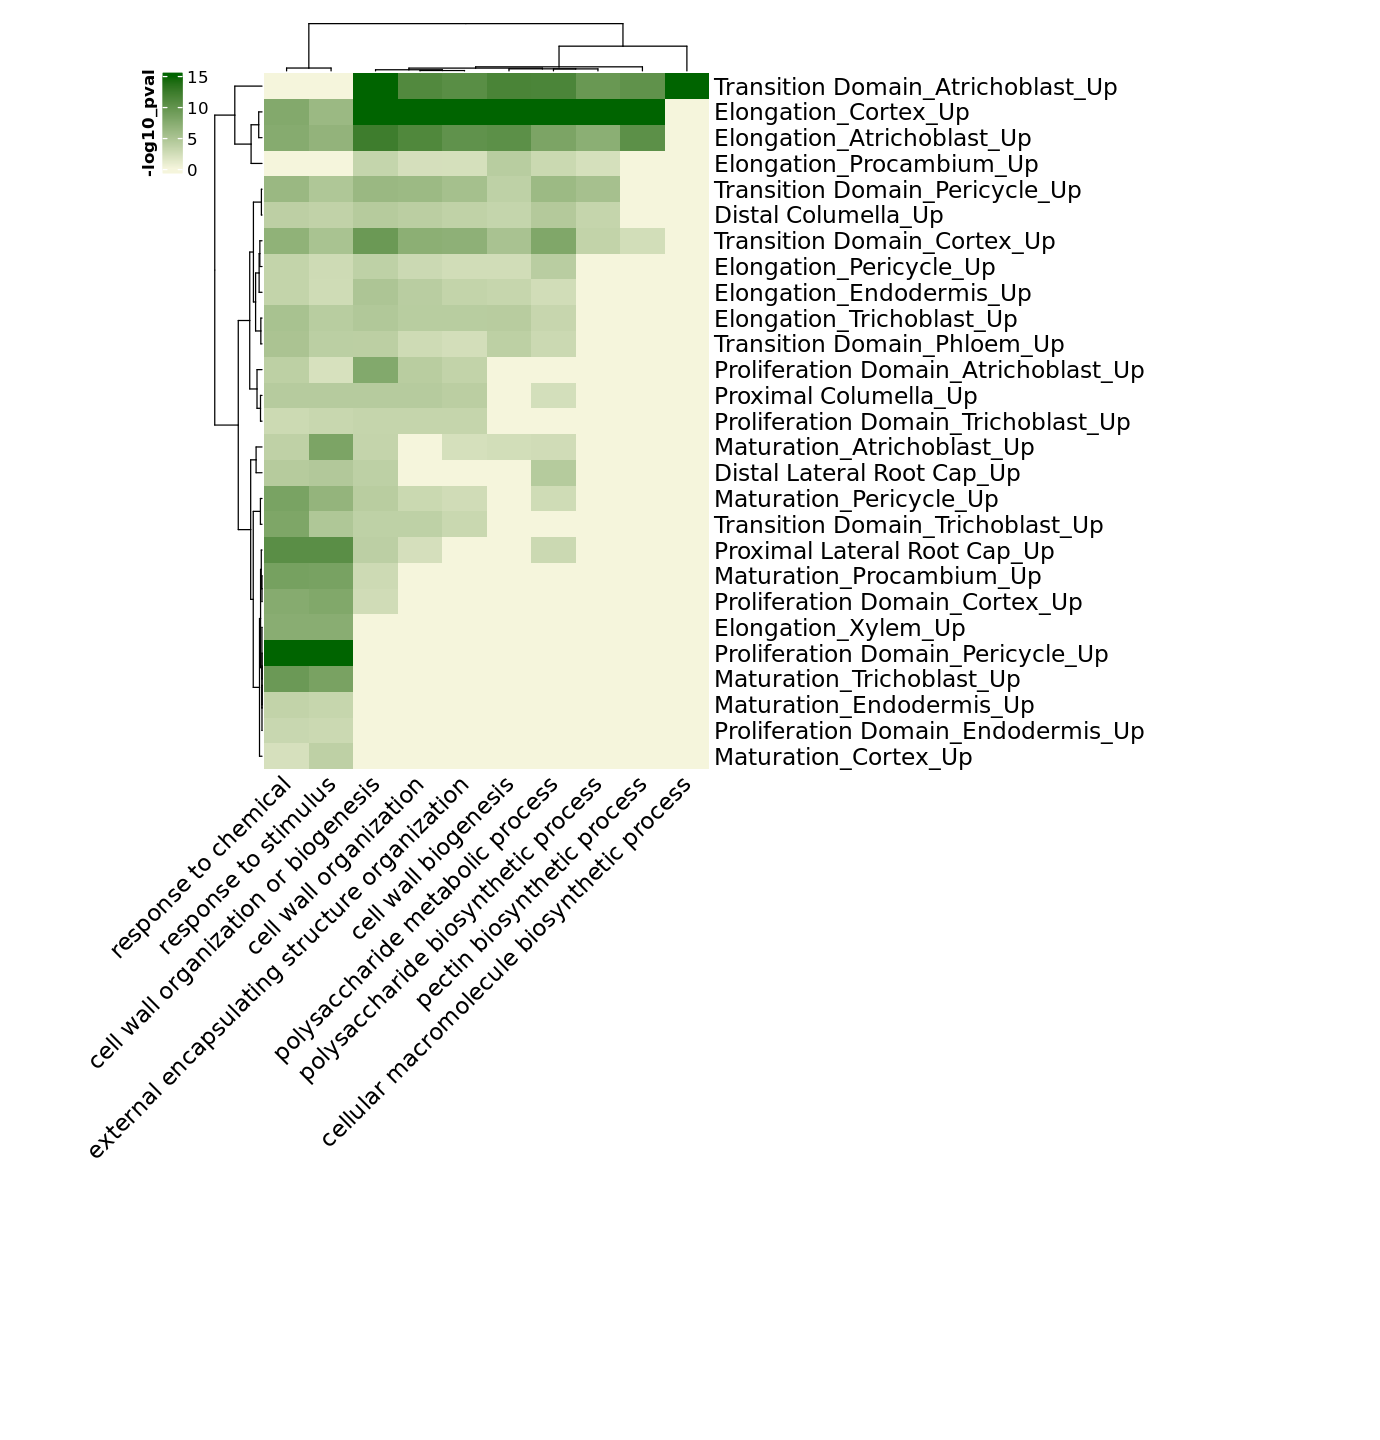

In [40]:
options(repr.plot.width = 11.5, repr.plot.height = 12)

# padding - bottom, left, top, right
draw(GO_hm_t, padding = unit(c(80, 30, 5, 80), "mm"), heatmap_legend_side = "left")

In [41]:
pdf("./output/BL_up_top_10_GO_hm.pdf", width = 11.5, height = 12)

# padding - bottom, left, top, right
draw(GO_hm_t, padding = unit(c(80, 30, 5, 80), "mm"), heatmap_legend_side = "left")


dev.off()

png 
  2

In [42]:
# numbers of BR genes to add as metadata

(BR_total_n <- sig_DE_fil %>% select(cluster_id, gene) %>% group_by(cluster_id) %>% tally(name = "total_DE"))

cluster_id                        total_DE
1  Distal Columella                   779    
2  Distal Lateral Root Cap            494    
3  Elongation_Atrichoblast           2328    
4  Elongation_Cortex                 2123    
5  Elongation_Endodermis             1626    
6  Elongation_Pericycle               944    
7  Elongation_Phloem                  588    
8  Elongation_Procambium              871    
9  Elongation_Trichoblast            1642    
10 Elongation_Xylem                  1022    
11 Maturation_Atrichoblast            968    
12 Maturation_Cortex                  154    
13 Maturation_Endodermis              166    
14 Maturation_Pericycle               820    
15 Maturation_Phloem                  120    
16 Maturation_Procambium              451    
17 Maturation_Trichoblast             754    
18 Maturation_Xylem                    31    
19 Proliferation Domain_Atrichoblast 1776    
20 Proliferation Domain_Cortex        231    
21 Proliferation Domain_Endodermis     62    
22 Proliferation Domain_Pericycle     503    
23 Proliferation Domain_Trichoblast  1331    
24 Proximal Columella                 369    
25 Proximal Lateral Root Cap         1032    
26 Transition Domain_Atrichoblast    2904    
27 Transition Domain_Cortex          1770    
28 Transition Domain_Pericycle        531    
29 Transition Domain_Phloem           227    
30 Transition Domain_Trichoblast     1701

In [43]:
(BR_up_n <- sig_DE_fil %>% filter(up_dn_label=="Up") %>% 
 select(cluster_id, gene) %>% group_by(cluster_id) %>% tally(name = "BL_Up"))

cluster_id                        BL_Up
1  Distal Columella                   317 
2  Distal Lateral Root Cap            294 
3  Elongation_Atrichoblast           1269 
4  Elongation_Cortex                  967 
5  Elongation_Endodermis              728 
6  Elongation_Pericycle               443 
7  Elongation_Phloem                  215 
8  Elongation_Procambium              459 
9  Elongation_Trichoblast             820 
10 Elongation_Xylem                   455 
11 Maturation_Atrichoblast            541 
12 Maturation_Cortex                   71 
13 Maturation_Endodermis               76 
14 Maturation_Pericycle               435 
15 Maturation_Phloem                   57 
16 Maturation_Procambium              241 
17 Maturation_Trichoblast             408 
18 Maturation_Xylem                     4 
19 Proliferation Domain_Atrichoblast  764 
20 Proliferation Domain_Cortex        158 
21 Proliferation Domain_Endodermis     53 
22 Proliferation Domain_Pericycle     349 
23 Proliferation Domain_Trichoblast   662 
24 Proximal Columella                 225 
25 Proximal Lateral Root Cap          620 
26 Transition Domain_Atrichoblast    1497 
27 Transition Domain_Cortex           861 
28 Transition Domain_Pericycle        338 
29 Transition Domain_Phloem           174 
30 Transition Domain_Trichoblast      861

In [44]:
(BR_dn_n <- sig_DE_fil %>% filter(up_dn_label=="Down") %>% 
 select(cluster_id, gene) %>% group_by(cluster_id) %>% tally(name = "BL_Down"))

cluster_id                        BL_Down
1  Distal Columella                   462   
2  Distal Lateral Root Cap            200   
3  Elongation_Atrichoblast           1059   
4  Elongation_Cortex                 1156   
5  Elongation_Endodermis              898   
6  Elongation_Pericycle               501   
7  Elongation_Phloem                  373   
8  Elongation_Procambium              412   
9  Elongation_Trichoblast             822   
10 Elongation_Xylem                   567   
11 Maturation_Atrichoblast            427   
12 Maturation_Cortex                   83   
13 Maturation_Endodermis               90   
14 Maturation_Pericycle               385   
15 Maturation_Phloem                   63   
16 Maturation_Procambium              210   
17 Maturation_Trichoblast             346   
18 Maturation_Xylem                    27   
19 Proliferation Domain_Atrichoblast 1012   
20 Proliferation Domain_Cortex         73   
21 Proliferation Domain_Endodermis      9   
22 Proliferation Domain_Pericycle     154   
23 Proliferation Domain_Trichoblast   669   
24 Proximal Columella                 144   
25 Proximal Lateral Root Cap          412   
26 Transition Domain_Atrichoblast    1407   
27 Transition Domain_Cortex           909   
28 Transition Domain_Pericycle        193   
29 Transition Domain_Phloem            53   
30 Transition Domain_Trichoblast      840

In [45]:
(bg_n <- all_bg %>% 
 select(cluster_id, gene) %>% 
group_by(cluster_id) %>% 
tally(name = "All_genes"))

cluster_id                        All_genes
1  Distal Columella                   5692    
2  Distal Lateral Root Cap            4689    
3  Elongation_Atrichoblast            7976    
4  Elongation_Cortex                  8657    
5  Elongation_Endodermis             10970    
6  Elongation_Pericycle              10028    
7  Elongation_Phloem                  7276    
8  Elongation_Procambium              6651    
9  Elongation_Trichoblast             8946    
10 Elongation_Xylem                   9988    
11 Maturation_Atrichoblast            6954    
12 Maturation_Cortex                  7653    
13 Maturation_Endodermis              8481    
14 Maturation_Pericycle              12468    
15 Maturation_Phloem                  8337    
16 Maturation_Procambium              9618    
17 Maturation_Trichoblast             9461    
18 Maturation_Xylem                   5756    
19 Proliferation Domain_Atrichoblast 13613    
20 Proliferation Domain_Cortex       13260    
21 Proliferation Domain_Endodermis   13190    
22 Proliferation Domain_Pericycle    14095    
23 Proliferation Domain_Trichoblast  13709    
24 Proximal Columella                 7862    
25 Proximal Lateral Root Cap          8606    
26 Transition Domain_Atrichoblast    11266    
27 Transition Domain_Cortex           9935    
28 Transition Domain_Pericycle       13162    
29 Transition Domain_Phloem           8928    
30 Transition Domain_Trichoblast     10674

In [46]:
(de_meta_for_umap <- data.frame("barcode"=colnames(integrated.de), 
                               "cluster_id"=integrated.de$time_zone_cell_type))

barcode             cluster_id                       
AAACCCAAGAGGCCAT_3  AAACCCAAGAGGCCAT_3  Transition Domain_Cortex         
AAACCCAAGCCTGTGC_3  AAACCCAAGCCTGTGC_3  Proximal Lateral Root Cap        
AAACCCAGTCAACGCC_3  AAACCCAGTCAACGCC_3  Proximal Lateral Root Cap        
AAACCCATCCATTGGA_3  AAACCCATCCATTGGA_3  Elongation_Cortex                
AAACCCATCGATACTG_3  AAACCCATCGATACTG_3  Elongation_Endodermis            
AAACCCATCGCGTAGC_3  AAACCCATCGCGTAGC_3  Proximal Columella               
AAACCCATCTAACGCA_3  AAACCCATCTAACGCA_3  Maturation_Trichoblast           
AAACCCATCTTACGGA_3  AAACCCATCTTACGGA_3  Distal Lateral Root Cap          
AAACGAAAGACATCAA_3  AAACGAAAGACATCAA_3  Elongation_Endodermis            
AAACGAAAGCCTCTTC_3  AAACGAAAGCCTCTTC_3  Proximal Columella               
AAACGAAAGGGAGGGT_3  AAACGAAAGGGAGGGT_3  Distal Columella                 
AAACGAACAGCTGTCG_3  AAACGAACAGCTGTCG_3  Maturation_Trichoblast           
AAACGAACAGGTCCGT_3  AAACGAACAGGTCCGT_3  Proximal Lateral Root Cap        
AAACGAACATTCACCC_3  AAACGAACATTCACCC_3  Proximal Lateral Root Cap        
AAACGAAGTAATGATG_3  AAACGAAGTAATGATG_3  Elongation_Endodermis            
AAACGAAGTGCAGGAT_3  AAACGAAGTGCAGGAT_3  Proximal Lateral Root Cap        
AAACGAAGTTGTAGCT_3  AAACGAAGTTGTAGCT_3  Elongation_Pericycle             
AAACGAATCACTACTT_3  AAACGAATCACTACTT_3  Proliferation Domain_Trichoblast 
AAACGCTAGACTCATC_3  AAACGCTAGACTCATC_3  Proximal Lateral Root Cap        
AAACGCTAGAGCTTTC_3  AAACGCTAGAGCTTTC_3  Distal Columella                 
AAACGCTAGTGCTAGG_3  AAACGCTAGTGCTAGG_3  Proximal Lateral Root Cap        
AAACGCTCAAAGGCAC_3  AAACGCTCAAAGGCAC_3  Proximal Lateral Root Cap        
AAACGCTGTACAACGG_3  AAACGCTGTACAACGG_3  Transition Domain_Cortex         
AAACGCTGTAGCGATG_3  AAACGCTGTAGCGATG_3  Distal Columella                 
AAAGAACAGATGTTCC_3  AAAGAACAGATGTTCC_3  Transition Domain_Atrichoblast   
AAAGAACAGCATACTC_3  AAAGAACAGCATACTC_3  Maturation_Endodermis            
AAAGAACAGGCATGCA_3  AAAGAACAGGCATGCA_3  Proximal Lateral Root Cap        
AAAGAACAGGCCCACT_3  AAAGAACAGGCCCACT_3  Elongation_Endodermis            
AAAGAACAGTAATCCC_3  AAAGAACAGTAATCCC_3  Elongation_Atrichoblast          
AAAGAACCAACCGTAT_3  AAAGAACCAACCGTAT_3  Proximal Lateral Root Cap        
⋮                   ⋮                   ⋮                                
TTTCGATGTCTCGACG_12 TTTCGATGTCTCGACG_12 Elongation_Pericycle             
TTTCGATTCATTGCCC_12 TTTCGATTCATTGCCC_12 Elongation_Pericycle             
TTTCGATTCCGTGGCA_12 TTTCGATTCCGTGGCA_12 Proliferation Domain_Atrichoblast
TTTGACTAGTCATGGG_12 TTTGACTAGTCATGGG_12 Proliferation Domain_Trichoblast 
TTTGACTAGTCCTACA_12 TTTGACTAGTCCTACA_12 Distal Lateral Root Cap          
TTTGACTCAACACTAC_12 TTTGACTCAACACTAC_12 Elongation_Procambium            
TTTGACTCATGGGTTT_12 TTTGACTCATGGGTTT_12 Distal Lateral Root Cap          
TTTGACTCATTCCTAT_12 TTTGACTCATTCCTAT_12 Maturation_Procambium            
TTTGACTGTGACCGTC_12 TTTGACTGTGACCGTC_12 Elongation_Atrichoblast          
TTTGACTGTGCTGCAC_12 TTTGACTGTGCTGCAC_12 Proliferation Domain_Atrichoblast
TTTGATCAGGTGCTGA_12 TTTGATCAGGTGCTGA_12 Elongation_Phloem                
TTTGATCCAAGCAATA_12 TTTGATCCAAGCAATA_12 Elongation_Procambium            
TTTGATCCATCGGAGA_12 TTTGATCCATCGGAGA_12 Elongation_Atrichoblast          
TTTGATCGTCCTCATC_12 TTTGATCGTCCTCATC_12 Proximal Lateral Root Cap        
TTTGATCTCCTGGGAC_12 TTTGATCTCCTGGGAC_12 Distal Lateral Root Cap          
TTTGATCTCGAAGCCC_12 TTTGATCTCGAAGCCC_12 Maturation_Atrichoblast          
TTTGGAGCACCGTGCA_12 TTTGGAGCACCGTGCA_12 Elongation_Phloem                
TTTGGAGCATGAAGGC_12 TTTGGAGCATGAAGGC_12 Proximal Lateral Root Cap        
TTTGGTTAGAACAAGG_12 TTTGGTTAGAACAAGG_12 Elongation_Procambium            
TTTGGTTAGCGTCTGC_12 TTTGGTTAGCGTCTGC_12 Elongation_Procambium            
TTTGGTTAGTAGGATT_12 TTTGGTTAGTAGGATT_12 Transition Domain_Trichoblast    
TTTGGTTAGTCTAGAA_12 TTTGGTTAGTCTAGAA_12 Maturation_Trichoblast           
TTTGGTTGTGTTAAAG_12 TTTG

In [47]:
de_meta_for_umap <- left_join(de_meta_for_umap, bg_n)

de_meta_for_umap <- left_join(de_meta_for_umap, BR_total_n)

de_meta_for_umap <- left_join(de_meta_for_umap, BR_up_n)

(de_meta_for_umap <- left_join(de_meta_for_umap, BR_dn_n))



Joining, by = "cluster_id"

Joining, by = "cluster_id"

Joining, by = "cluster_id"

Joining, by = "cluster_id"



barcode             cluster_id                        All_genes total_DE
1     AAACCCAAGAGGCCAT_3  Transition Domain_Cortex           9935     1770    
2     AAACCCAAGCCTGTGC_3  Proximal Lateral Root Cap          8606     1032    
3     AAACCCAGTCAACGCC_3  Proximal Lateral Root Cap          8606     1032    
4     AAACCCATCCATTGGA_3  Elongation_Cortex                  8657     2123    
5     AAACCCATCGATACTG_3  Elongation_Endodermis             10970     1626    
6     AAACCCATCGCGTAGC_3  Proximal Columella                 7862      369    
7     AAACCCATCTAACGCA_3  Maturation_Trichoblast             9461      754    
8     AAACCCATCTTACGGA_3  Distal Lateral Root Cap            4689      494    
9     AAACGAAAGACATCAA_3  Elongation_Endodermis             10970     1626    
10    AAACGAAAGCCTCTTC_3  Proximal Columella                 7862      369    
11    AAACGAAAGGGAGGGT_3  Distal Columella                   5692      779    
12    AAACGAACAGCTGTCG_3  Maturation_Trichoblast             9461      754    
13    AAACGAACAGGTCCGT_3  Proximal Lateral Root Cap          8606     1032    
14    AAACGAACATTCACCC_3  Proximal Lateral Root Cap          8606     1032    
15    AAACGAAGTAATGATG_3  Elongation_Endodermis             10970     1626    
16    AAACGAAGTGCAGGAT_3  Proximal Lateral Root Cap          8606     1032    
17    AAACGAAGTTGTAGCT_3  Elongation_Pericycle              10028      944    
18    AAACGAATCACTACTT_3  Proliferation Domain_Trichoblast  13709     1331    
19    AAACGCTAGACTCATC_3  Proximal Lateral Root Cap          8606     1032    
20    AAACGCTAGAGCTTTC_3  Distal Columella                   5692      779    
21    AAACGCTAGTGCTAGG_3  Proximal Lateral Root Cap          8606     1032    
22    AAACGCTCAAAGGCAC_3  Proximal Lateral Root Cap          8606     1032    
23    AAACGCTGTACAACGG_3  Transition Domain_Cortex           9935     1770    
24    AAACGCTGTAGCGATG_3  Distal Columella                   5692      779    
25    AAAGAACAGATGTTCC_3  Transition Domain_Atrichoblast    11266     2904    
26    AAAGAACAGCATACTC_3  Maturation_Endodermis              8481      166    
27    AAAGAACAGGCATGCA_3  Proximal Lateral Root Cap          8606     1032    
28    AAAGAACAGGCCCACT_3  Elongation_Endodermis             10970     1626    
29    AAAGAACAGTAATCCC_3  Elongation_Atrichoblast            7976     2328    
30    AAAGAACCAACCGTAT_3  Proximal Lateral Root Cap          8606     1032    
⋮     ⋮                   ⋮                                 ⋮         ⋮       
43719 TTTCGATGTCTCGACG_12 Elongation_Pericycle              10028      944    
43720 TTTCGATTCATTGCCC_12 Elongation_Pericycle              10028      944    
43721 TTTCGATTCCGTGGCA_12 Proliferation Domain_Atrichoblast 13613     1776    
43722 TTTGACTAGTCATGGG_12 Proliferation Domain_Trichoblast  13709     1331    
43723 TTTGACTAGTCCTACA_12 Distal Lateral Root Cap            4689      494    
43724 TTTGACTCAACACTAC_12 Elongation_Procambium              6651      871    
43725 TTTGACTCATGGGTTT_12 Distal Lateral Root Cap            4689      494    
43726 TTTGACTCATTCCTAT_12 Maturation_Procambium              9618      451    
43727 TTTGACTGTGACCGTC_12 Elongation_Atrichoblast            7976     2328    
43728 TTTGACTGTGCTGCAC_12 Proliferation Domain_Atrichoblast 13613     1776    
43729 TTTGATCAGGTGCTGA_12 Elongation_Phloem                  7276      588    
43730 TTTGATCCAAGCAATA_12 Elongation_Procambium              6651      871    
43731 TTTGATCCATCGGAGA_12 Elongation_Atrichoblast            7976     2328    
43732 TTTGATCGTCCTCATC_12 Proximal Lateral Root Cap          8606     1032    
43733 TTTGATCTCCTGGGAC_12 Distal Lateral Root Cap            4689      494    
43734 TTTGATCTCGAAGCCC_12 Maturation_Atrichoblast            6954      968    
43735 TTTGGAGCACCGTGCA_12 Elongation_Phloem                  7276      588    
43736 TTTGGAGCATGAAGGC_12 Proximal Lateral Root Cap          8606     1032    
43737 TTTGGTTAGAACAAGG_12 Elongation_Procambium         

In [48]:
# replace NA with zero for catagories that were too small to test 

de_meta_for_umap[is.na(de_meta_for_umap)] <- 0

In [49]:
(de_meta_for_umap)

barcode             cluster_id                        All_genes total_DE
1     AAACCCAAGAGGCCAT_3  Transition Domain_Cortex           9935     1770    
2     AAACCCAAGCCTGTGC_3  Proximal Lateral Root Cap          8606     1032    
3     AAACCCAGTCAACGCC_3  Proximal Lateral Root Cap          8606     1032    
4     AAACCCATCCATTGGA_3  Elongation_Cortex                  8657     2123    
5     AAACCCATCGATACTG_3  Elongation_Endodermis             10970     1626    
6     AAACCCATCGCGTAGC_3  Proximal Columella                 7862      369    
7     AAACCCATCTAACGCA_3  Maturation_Trichoblast             9461      754    
8     AAACCCATCTTACGGA_3  Distal Lateral Root Cap            4689      494    
9     AAACGAAAGACATCAA_3  Elongation_Endodermis             10970     1626    
10    AAACGAAAGCCTCTTC_3  Proximal Columella                 7862      369    
11    AAACGAAAGGGAGGGT_3  Distal Columella                   5692      779    
12    AAACGAACAGCTGTCG_3  Maturation_Trichoblast             9461      754    
13    AAACGAACAGGTCCGT_3  Proximal Lateral Root Cap          8606     1032    
14    AAACGAACATTCACCC_3  Proximal Lateral Root Cap          8606     1032    
15    AAACGAAGTAATGATG_3  Elongation_Endodermis             10970     1626    
16    AAACGAAGTGCAGGAT_3  Proximal Lateral Root Cap          8606     1032    
17    AAACGAAGTTGTAGCT_3  Elongation_Pericycle              10028      944    
18    AAACGAATCACTACTT_3  Proliferation Domain_Trichoblast  13709     1331    
19    AAACGCTAGACTCATC_3  Proximal Lateral Root Cap          8606     1032    
20    AAACGCTAGAGCTTTC_3  Distal Columella                   5692      779    
21    AAACGCTAGTGCTAGG_3  Proximal Lateral Root Cap          8606     1032    
22    AAACGCTCAAAGGCAC_3  Proximal Lateral Root Cap          8606     1032    
23    AAACGCTGTACAACGG_3  Transition Domain_Cortex           9935     1770    
24    AAACGCTGTAGCGATG_3  Distal Columella                   5692      779    
25    AAAGAACAGATGTTCC_3  Transition Domain_Atrichoblast    11266     2904    
26    AAAGAACAGCATACTC_3  Maturation_Endodermis              8481      166    
27    AAAGAACAGGCATGCA_3  Proximal Lateral Root Cap          8606     1032    
28    AAAGAACAGGCCCACT_3  Elongation_Endodermis             10970     1626    
29    AAAGAACAGTAATCCC_3  Elongation_Atrichoblast            7976     2328    
30    AAAGAACCAACCGTAT_3  Proximal Lateral Root Cap          8606     1032    
⋮     ⋮                   ⋮                                 ⋮         ⋮       
43719 TTTCGATGTCTCGACG_12 Elongation_Pericycle              10028      944    
43720 TTTCGATTCATTGCCC_12 Elongation_Pericycle              10028      944    
43721 TTTCGATTCCGTGGCA_12 Proliferation Domain_Atrichoblast 13613     1776    
43722 TTTGACTAGTCATGGG_12 Proliferation Domain_Trichoblast  13709     1331    
43723 TTTGACTAGTCCTACA_12 Distal Lateral Root Cap            4689      494    
43724 TTTGACTCAACACTAC_12 Elongation_Procambium              6651      871    
43725 TTTGACTCATGGGTTT_12 Distal Lateral Root Cap            4689      494    
43726 TTTGACTCATTCCTAT_12 Maturation_Procambium              9618      451    
43727 TTTGACTGTGACCGTC_12 Elongation_Atrichoblast            7976     2328    
43728 TTTGACTGTGCTGCAC_12 Proliferation Domain_Atrichoblast 13613     1776    
43729 TTTGATCAGGTGCTGA_12 Elongation_Phloem                  7276      588    
43730 TTTGATCCAAGCAATA_12 Elongation_Procambium              6651      871    
43731 TTTGATCCATCGGAGA_12 Elongation_Atrichoblast            7976     2328    
43732 TTTGATCGTCCTCATC_12 Proximal Lateral Root Cap          8606     1032    
43733 TTTGATCTCCTGGGAC_12 Distal Lateral Root Cap            4689      494    
43734 TTTGATCTCGAAGCCC_12 Maturation_Atrichoblast            6954      968    
43735 TTTGGAGCACCGTGCA_12 Elongation_Phloem                  7276      588    
43736 TTTGGAGCATGAAGGC_12 Proximal Lateral Root Cap          8606     1032    
43737 TTTGGTTAGAACAAGG_12 Elongation_Procambium         

In [50]:
(de_meta_for_umap <- mutate(de_meta_for_umap, 
                          Percent_DE=(total_DE/All_genes)*100,
                          Percent_Up=(BL_Up/All_genes)*100,
                          Percent_Dn=(BL_Down/All_genes)*100))

barcode             cluster_id                        All_genes total_DE
1     AAACCCAAGAGGCCAT_3  Transition Domain_Cortex           9935     1770    
2     AAACCCAAGCCTGTGC_3  Proximal Lateral Root Cap          8606     1032    
3     AAACCCAGTCAACGCC_3  Proximal Lateral Root Cap          8606     1032    
4     AAACCCATCCATTGGA_3  Elongation_Cortex                  8657     2123    
5     AAACCCATCGATACTG_3  Elongation_Endodermis             10970     1626    
6     AAACCCATCGCGTAGC_3  Proximal Columella                 7862      369    
7     AAACCCATCTAACGCA_3  Maturation_Trichoblast             9461      754    
8     AAACCCATCTTACGGA_3  Distal Lateral Root Cap            4689      494    
9     AAACGAAAGACATCAA_3  Elongation_Endodermis             10970     1626    
10    AAACGAAAGCCTCTTC_3  Proximal Columella                 7862      369    
11    AAACGAAAGGGAGGGT_3  Distal Columella                   5692      779    
12    AAACGAACAGCTGTCG_3  Maturation_Trichoblast             9461      754    
13    AAACGAACAGGTCCGT_3  Proximal Lateral Root Cap          8606     1032    
14    AAACGAACATTCACCC_3  Proximal Lateral Root Cap          8606     1032    
15    AAACGAAGTAATGATG_3  Elongation_Endodermis             10970     1626    
16    AAACGAAGTGCAGGAT_3  Proximal Lateral Root Cap          8606     1032    
17    AAACGAAGTTGTAGCT_3  Elongation_Pericycle              10028      944    
18    AAACGAATCACTACTT_3  Proliferation Domain_Trichoblast  13709     1331    
19    AAACGCTAGACTCATC_3  Proximal Lateral Root Cap          8606     1032    
20    AAACGCTAGAGCTTTC_3  Distal Columella                   5692      779    
21    AAACGCTAGTGCTAGG_3  Proximal Lateral Root Cap          8606     1032    
22    AAACGCTCAAAGGCAC_3  Proximal Lateral Root Cap          8606     1032    
23    AAACGCTGTACAACGG_3  Transition Domain_Cortex           9935     1770    
24    AAACGCTGTAGCGATG_3  Distal Columella                   5692      779    
25    AAAGAACAGATGTTCC_3  Transition Domain_Atrichoblast    11266     2904    
26    AAAGAACAGCATACTC_3  Maturation_Endodermis              8481      166    
27    AAAGAACAGGCATGCA_3  Proximal Lateral Root Cap          8606     1032    
28    AAAGAACAGGCCCACT_3  Elongation_Endodermis             10970     1626    
29    AAAGAACAGTAATCCC_3  Elongation_Atrichoblast            7976     2328    
30    AAAGAACCAACCGTAT_3  Proximal Lateral Root Cap          8606     1032    
⋮     ⋮                   ⋮                                 ⋮         ⋮       
43719 TTTCGATGTCTCGACG_12 Elongation_Pericycle              10028      944    
43720 TTTCGATTCATTGCCC_12 Elongation_Pericycle              10028      944    
43721 TTTCGATTCCGTGGCA_12 Proliferation Domain_Atrichoblast 13613     1776    
43722 TTTGACTAGTCATGGG_12 Proliferation Domain_Trichoblast  13709     1331    
43723 TTTGACTAGTCCTACA_12 Distal Lateral Root Cap            4689      494    
43724 TTTGACTCAACACTAC_12 Elongation_Procambium              6651      871    
43725 TTTGACTCATGGGTTT_12 Distal Lateral Root Cap            4689      494    
43726 TTTGACTCATTCCTAT_12 Maturation_Procambium              9618      451    
43727 TTTGACTGTGACCGTC_12 Elongation_Atrichoblast            7976     2328    
43728 TTTGACTGTGCTGCAC_12 Proliferation Domain_Atrichoblast 13613     1776    
43729 TTTGATCAGGTGCTGA_12 Elongation_Phloem                  7276      588    
43730 TTTGATCCAAGCAATA_12 Elongation_Procambium              6651      871    
43731 TTTGATCCATCGGAGA_12 Elongation_Atrichoblast            7976     2328    
43732 TTTGATCGTCCTCATC_12 Proximal Lateral Root Cap          8606     1032    
43733 TTTGATCTCCTGGGAC_12 Distal Lateral Root Cap            4689      494    
43734 TTTGATCTCGAAGCCC_12 Maturation_Atrichoblast            6954      968    
43735 TTTGGAGCACCGTGCA_12 Elongation_Phloem                  7276      588    
43736 TTTGGAGCATGAAGGC_12 Proximal Lateral Root Cap          8606     1032    
43737 TTTGGTTAGAACAAGG_12 Elongation_Procambium         

In [51]:
total_de_meta <- de_meta_for_umap$total_DE
names(total_de_meta) <- colnames(integrated.de)

integrated.de <- AddMetaData(
  object = integrated.de,
  metadata = total_de_meta,
  col.name = 'total_DE')

up_de_meta <- de_meta_for_umap$BL_Up
names(up_de_meta) <- colnames(integrated.de)

integrated.de <- AddMetaData(
  object = integrated.de,
  metadata = up_de_meta,
  col.name = 'BL_Up')


dn_de_meta <- de_meta_for_umap$BL_Down
names(dn_de_meta) <- colnames(integrated.de)

integrated.de <- AddMetaData(
  object = integrated.de,
  metadata = dn_de_meta,
  col.name = 'BL_Down')

# percentages

total_de_meta_p <- de_meta_for_umap$Percent_DE
names(total_de_meta_p) <- colnames(integrated.de)

integrated.de <- AddMetaData(
  object = integrated.de,
  metadata = total_de_meta_p,
  col.name = 'percent_DE')

up_de_meta_p <- de_meta_for_umap$Percent_Up
names(up_de_meta_p) <- colnames(integrated.de)

integrated.de <- AddMetaData(
  object = integrated.de,
  metadata = up_de_meta_p,
  col.name = 'Percent_BL_Up')


dn_de_meta_p <- de_meta_for_umap$Percent_Dn
names(dn_de_meta_p) <- colnames(integrated.de)

integrated.de <- AddMetaData(
  object = integrated.de,
  metadata = dn_de_meta_p,
  col.name = 'Percent_BL_Down')



In [52]:

bl_de_plt <- FeaturePlot(integrated.de, 
                         features = c("total_DE"), 
                         max.cutoff = 2000, 
                         label=F, 
                         order = T, 
                         cols=c("beige", "#01665e"), 
                         pt.size = 0.5) + 
                            ggtitle("Total BL DE genes") +  
                            theme_void(base_size = 16) + 
                            theme(plot.title = element_text(hjust = 0.5)) +
                                 labs(color="# genes") +  theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"))


bl_up_plt <- FeaturePlot(integrated.de, 
                         features = c("BL_Up"), 
                         max.cutoff = 1000, 
                         label=F, order = T, 
                         cols=c("beige", "red"), 
                         pt.size = 0.5) + 
                            ggtitle("BL up-regulated genes") +  
                            theme_void(base_size = 16) + 
                            theme(plot.title = element_text(hjust = 0.5)) +
                                 labs(color="# genes") +  theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"))

bl_dn_plt <- FeaturePlot(integrated.de, 
                         features = c("BL_Down"), 
                         max.cutoff = 1000, 
                         label=F, 
                         order = T, 
                         cols=c("beige", "blue"), 
                         pt.size = 0.5) + 
                            ggtitle("BL down-regulated genes") +  
                            theme_void(base_size = 16) + 
                            theme(plot.title = element_text(hjust = 0.5)) +
                                 labs(color="# genes") +  theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm"))

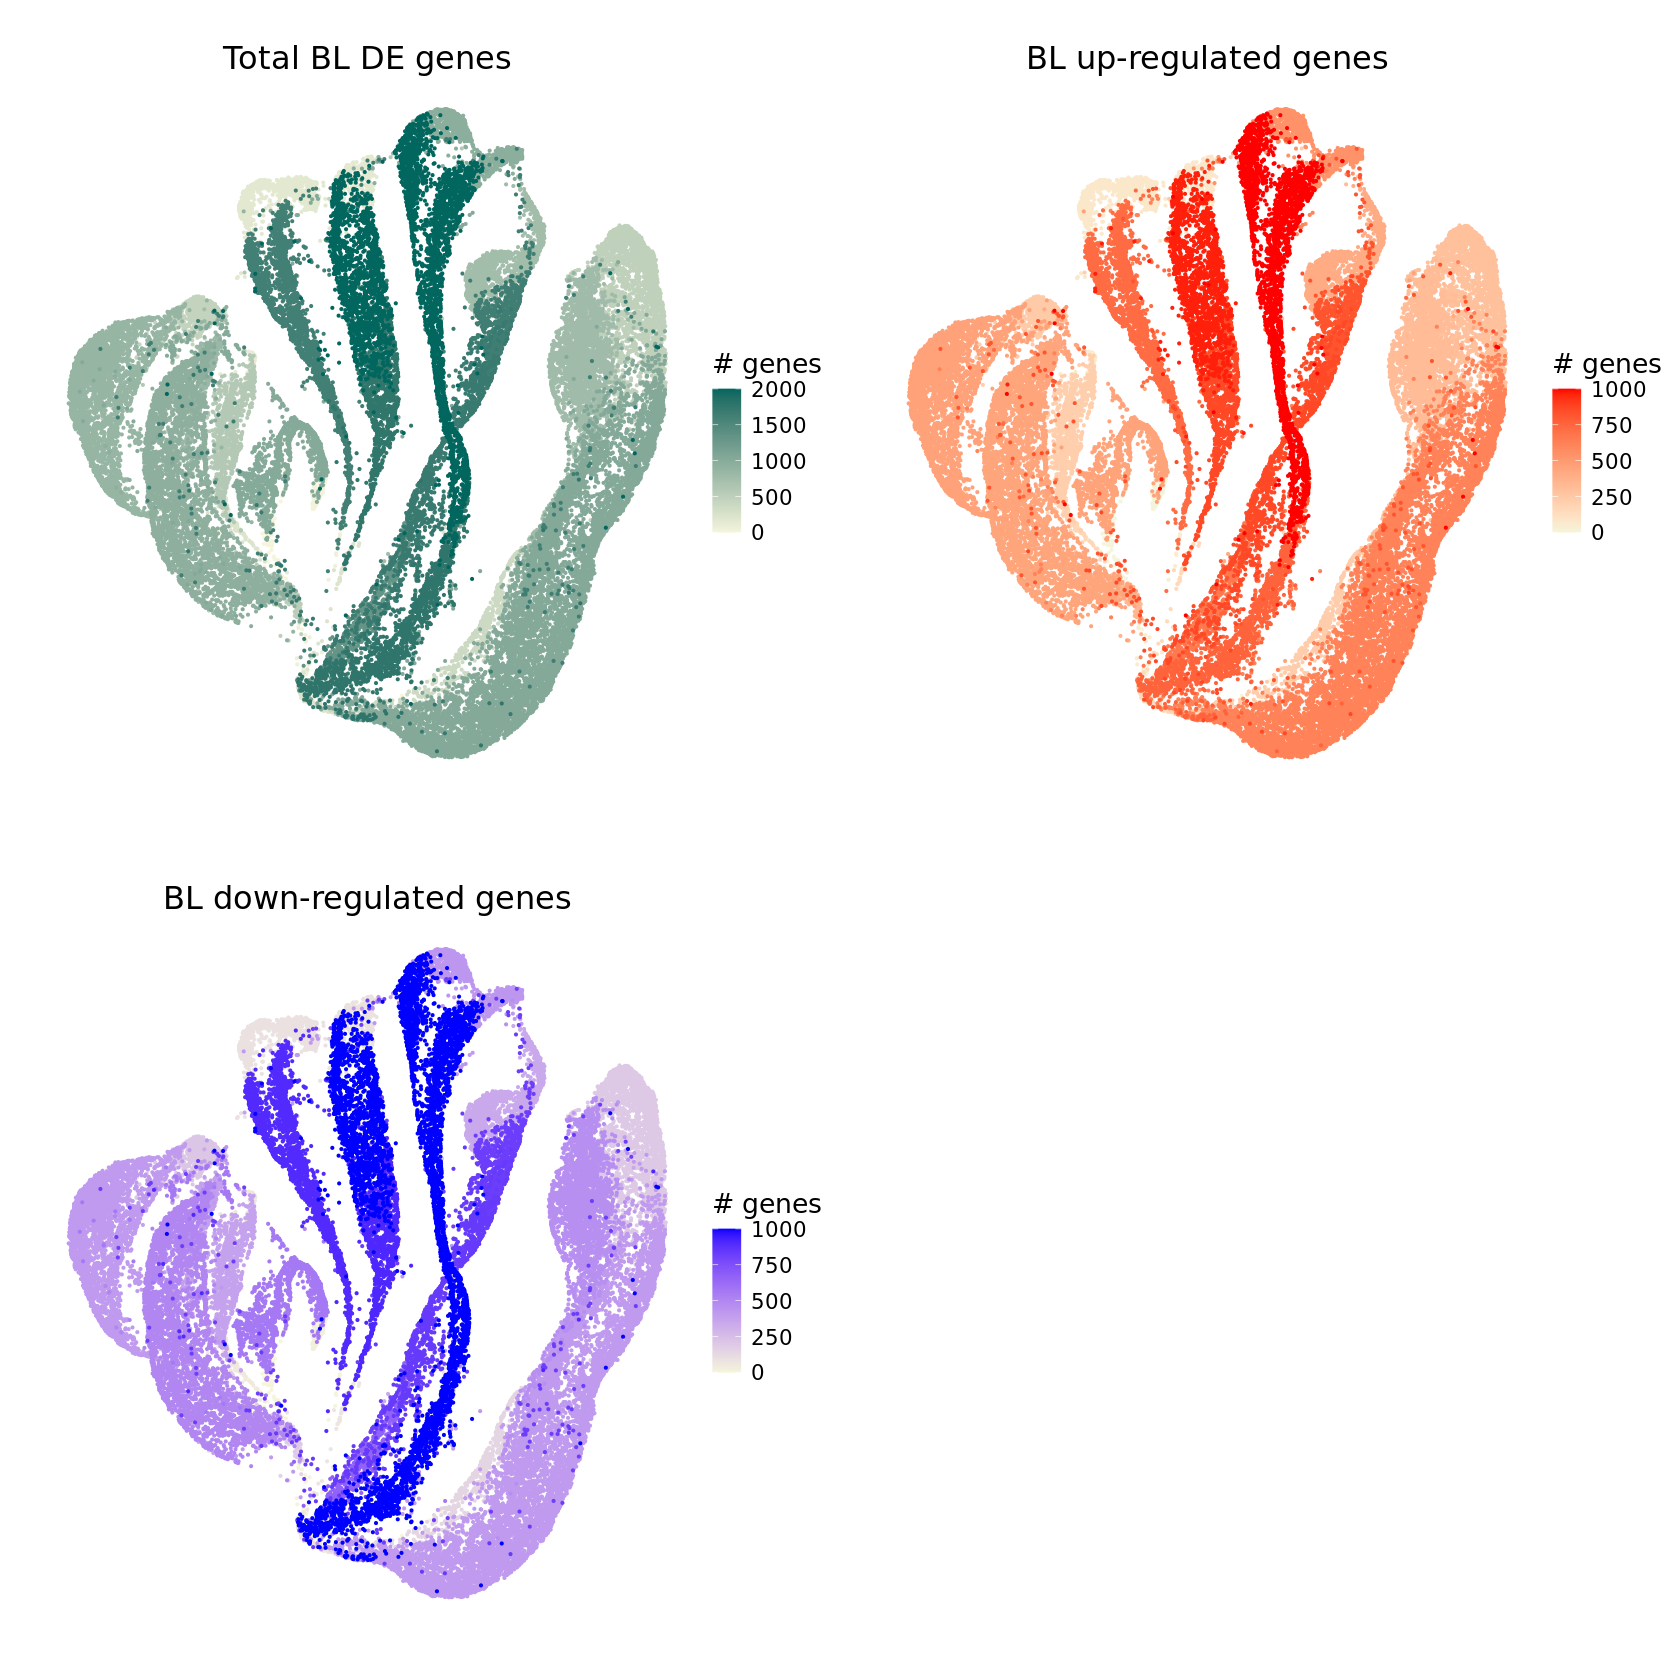

In [53]:
options(repr.plot.width = 14, repr.plot.height = 14)
plot_grid(bl_de_plt, bl_up_plt, bl_dn_plt, nrow=2) 


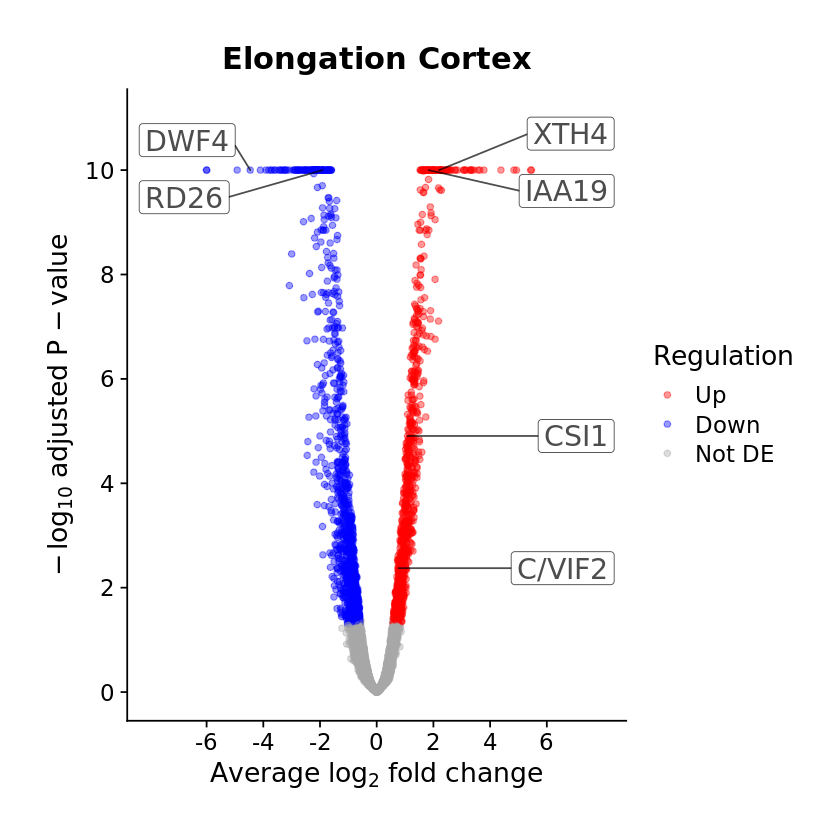

In [54]:
# volcano plot only for elong cortex 

options(repr.plot.width = 7, repr.plot.height = 7)
cortex_vol <- all_bg %>% filter(cluster_id=="Elongation_Cortex")

cortex_vol <- 
  mutate_at(cortex_vol, "Name", str_replace, "CYP90B1", "DWF4")


cortex_vol <- dplyr::rename(cortex_vol, log2FC=logFC)

cortex_vol$logFDR <- -log10(cortex_vol$p_adj.loc)
# color up/down and facet plot 

# filter(nb_de_total, p_val_adj<=0.05) %>%
# filter(avg_logFC>=log2(1.25) | avg_logFC<=log2(3/4))



cortex_vol$up_dn_label[is.na(cortex_vol$up_dn_label)] <- "Not DE"
cortex_vol$up_dn_label <- factor(cortex_vol$up_dn_label, levels=c("Up", "Down", "Not DE"))


cortex_vol$sig <- cortex_vol$up_dn_label !="Not DE"
# set limits of FC and logFDR
cortex_vol_cut <- cortex_vol
# round to cutoff at 4
cortex_vol_cut$logFDR[cortex_vol_cut$logFDR>10] <- 10

# limit log2FC to 4 
cortex_vol_cut$log2FC[cortex_vol_cut$log2FC>6] <- 6
cortex_vol_cut$log2FC[cortex_vol_cut$log2FC < -6] <- -6

# # labels 


up_genes_to_label <- filter(cortex_vol_cut, gene %in% c("AT2G22125", #CSI1
                                                    "AT5G64620", #C/VIF2
                                                    "AT2G06850", #XTH4
                                                    "AT3G15540" #IAA19
                                                   ))
down_genes_to_label <- filter(cortex_vol_cut, gene %in% c("AT3G50660", #DWF4
                                                    "AT4G27410" #RD26
                                                   ))


p = ggplot(cortex_vol_cut, aes(log2FC, logFDR)) +
  geom_point(aes(col=up_dn_label), alpha = 0.4) +
  scale_color_manual(values=c("red", "blue", "darkgrey")) + 
  scale_x_continuous(limits=c(-8, 8), breaks = c(-6, -4, -2, 0, 2, 4, 6)) + scale_y_continuous(limits=c(0, 11), breaks = c(0, 2, 4, 6, 8, 10)) + 
  xlab(expression(Average~log[2]~fold~change)) + 
  ylab(expression(-log[10]~adjusted~P~-value)) + 
  scale_alpha(guide="none")

all_plot <- p+ geom_label_repel(data=up_genes_to_label, 
                   aes(label=Name), 
                   size = 6, 
                   nudge_x = 11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) + 
  geom_label_repel(data=down_genes_to_label, 
                   aes(label=Name), 
                   size = 6, 
                   nudge_x = -11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) +
  labs(color = "Regulation") + ggtitle("") + theme_minimal() + theme(plot.title = element_text(hjust = 0.5))



(cortex_volcano <- all_plot  + ggtitle("Elongation Cortex") + theme_cowplot(font_size = 16) + 
                            theme(plot.title = element_text(hjust = 0.5)) +  theme(plot.margin = margin(1,1,1,1, "cm")))


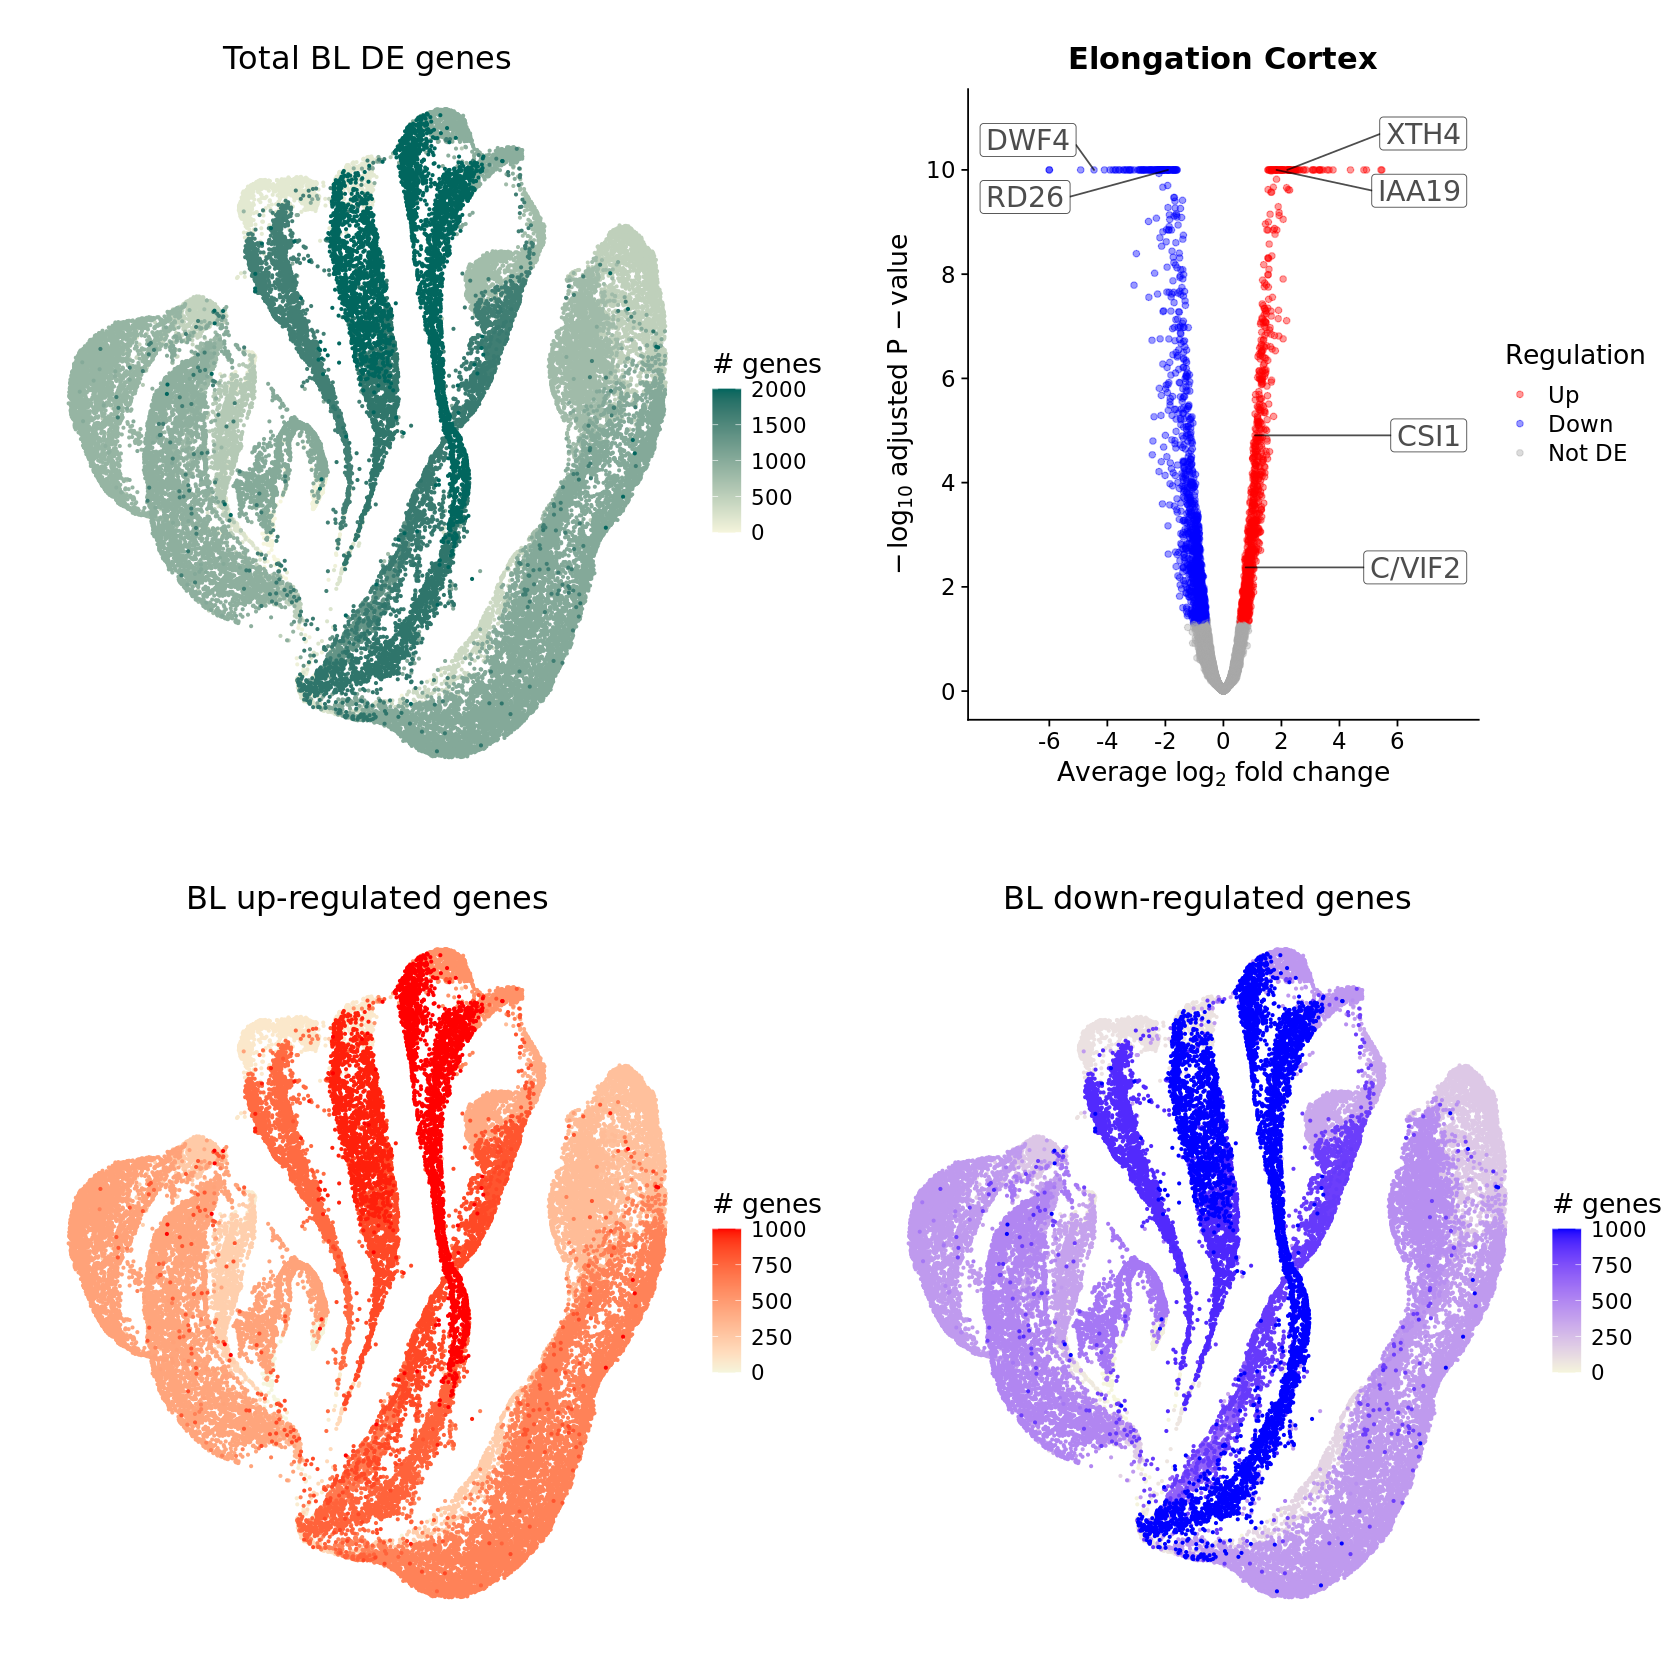

In [55]:
options(repr.plot.width = 14, repr.plot.height = 14)
(DE_and_volcano <- plot_grid(bl_de_plt, cortex_volcano, bl_up_plt, bl_dn_plt, nrow=2))
ggsave("./output/BL_DE_genes_on_umap.png", width = 14, height = 14)

In [56]:
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
integrated.de$cell_type <- factor(integrated.de$cell_type, levels = order[sort(match(unique(integrated.de$cell_type),order))])
color <- palette[sort(match(unique(integrated.de$cell_type),order))]

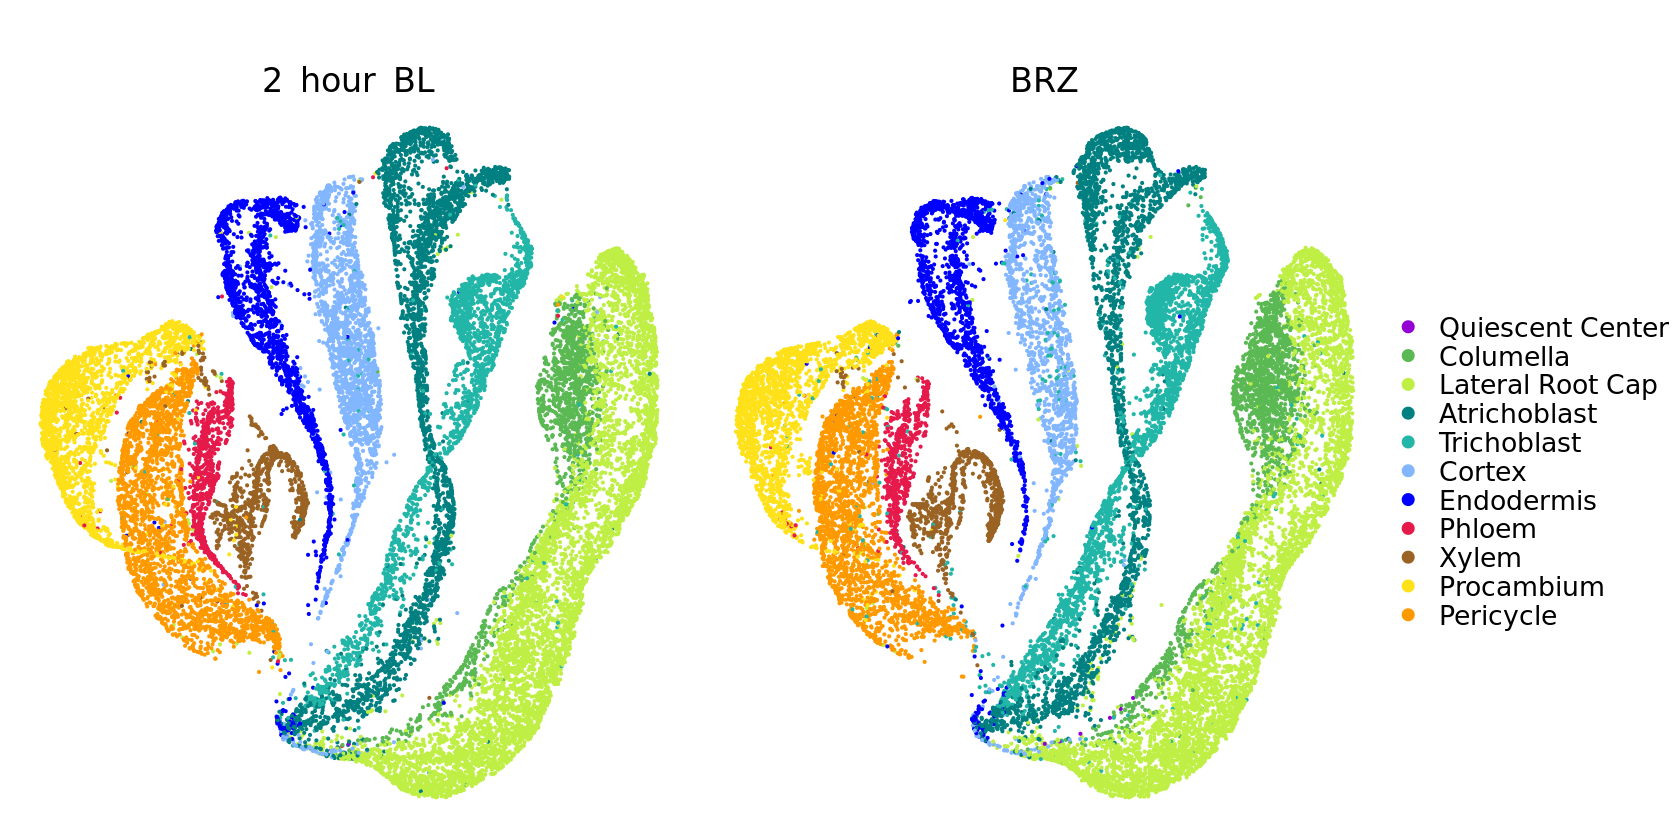

In [57]:
options(repr.plot.width=14, repr.plot.height=7)
(BR_2_cell <- DimPlot(integrated.de, 
                      reduction = "umap", 
                      group.by = "cell_type", 
                      cols = color, split.by = 'time_trt', 
                      ncol=2, 
                      pt.size = 0.5) + 
                        theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm")) + 
                         ggtitle("") +
                         theme_void(base_size = 20) &
                            theme(plot.title = element_text(hjust = 0.5)) +
theme(strip.text = NULL))

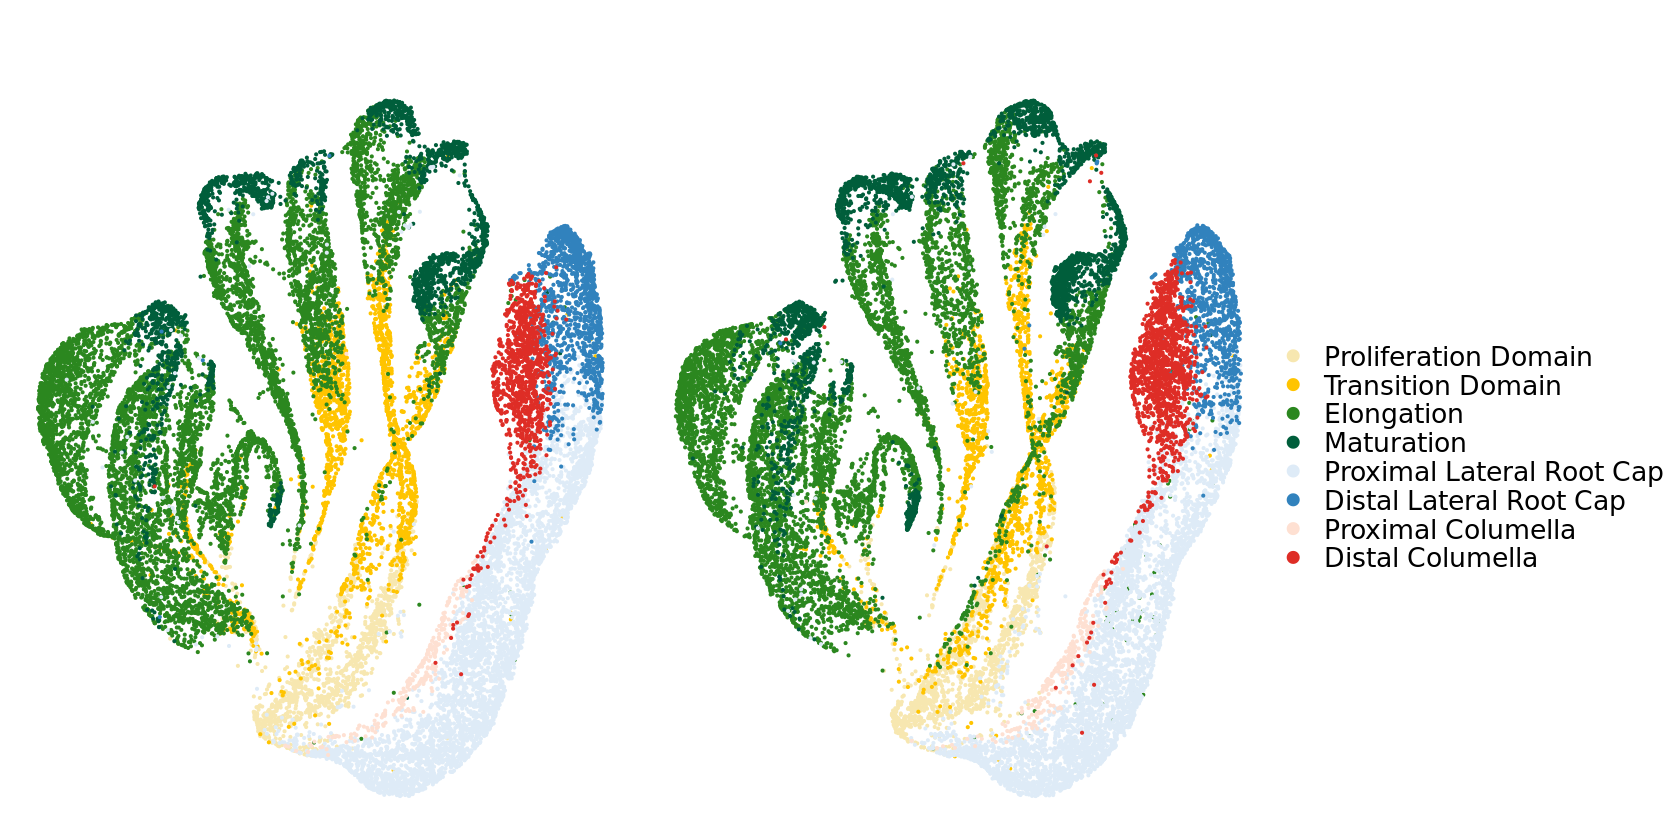

In [58]:
options(repr.plot.width=14, repr.plot.height=7)
(BR_2_time <- DimPlot(integrated.de, 
        group.by = "time_zone", 
                      split.by = 'time_trt', 
        order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26'),
        ncol=2, 
        pt.size = 0.5) + 
        theme(plot.margin = margin(0,0.5,0.5,0.5, "cm")) + 
        ggtitle("") +
        theme_void(base_size = 20) + theme(strip.text = element_text(size=0)))








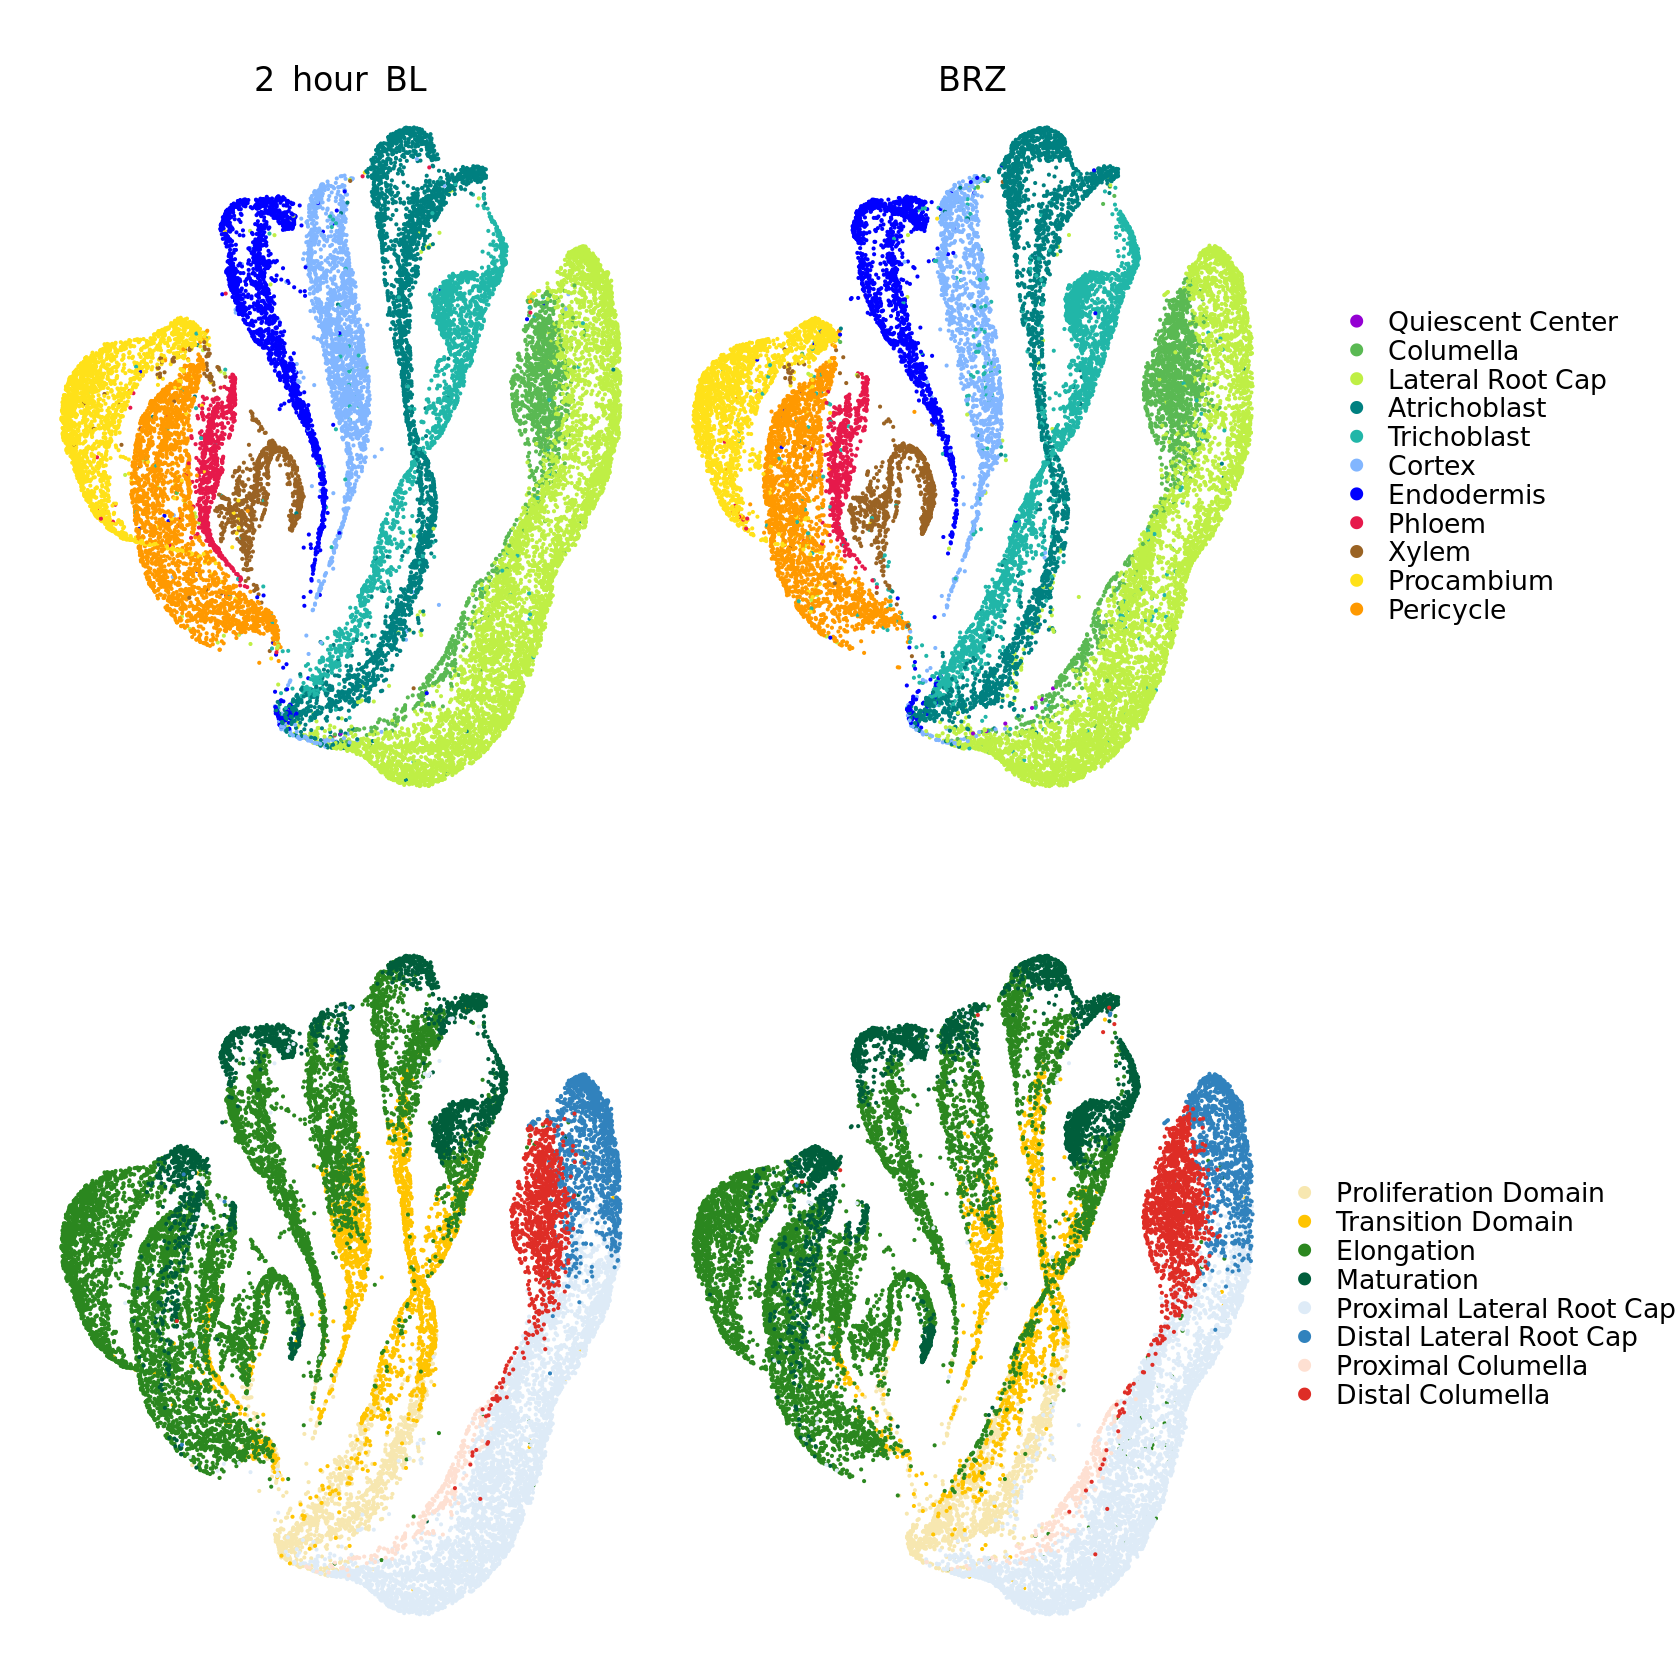

In [59]:
options(repr.plot.width=14, repr.plot.height=14)

(cell_time_umaps <- plot_grid(BR_2_cell, BR_2_time, ncol=1, align = "hv")+ 
        theme(plot.margin = margin(0,0.5,0.5,0.5, "cm")))
ggsave("./output/BL_2_hr_umap_cell_dev.png", width = 14, height = 14)